In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

%matplotlib inline

## Participant Data

This file contains all the participant video ratings collected during the experiment.

The start_time values were logged by the presentation software. Valence, arousal, dominance and liking were rated directly after each trial on a continuous 9-point scale using a standard mouse.

SAM Mannequins were used to visualize the ratings for valence, arousal and dominance. For liking (i.e. how much did you like the video?), thumbs up and thumbs down icons were used. 

Familiarity was rated after the end of the experiment on a 5-point integer scale (from "never heard it before" to "listen to it regularly"). Familiarity ratings are unfortunately missing for participants 2, 15 and 23.

| Column Name    | Information                                                                                       |
|----------------|---------------------------------------------------------------------------------------------------|
| Participant_id | The unique id of the participant (1-32).                                                          |
| Trial          | The trial number (i.e. the presentation order).                                                   |
| Experiment_id  | The video id corresponding to the same column in  the video_list file.                            |
| Start_time     | The starting time of the trial video playback  in microseconds (relative to start of experiment). |
| Valence        | The valence rating (float between 1 and 9).                                                       |
| Arousal        | The arousal rating (float between 1 and 9).                                                       |
| Dominance      | The dominance rating (float between 1 and 9).                                                     |
| Liking         | The liking rating (float between 1 and 9).                                                        |
| Familiarity    | The familiarity rating (integer between 1 and 5).  Blank if missing.                              |

In [2]:
PR = pd.read_csv('./dataset/metadata_csv/participant_ratings.csv')

In [3]:
PR.head()

,Participant_id,Trial,Experiment_id,Start_time,Valence,Arousal,Dominance,Liking,Familiarity
0,1,1,5,1695918,6.96,3.92,7.19,6.05,4.0
1,1,2,18,2714905,7.23,7.15,6.94,8.01,4.0
2,1,3,4,3586768,4.94,6.01,6.12,8.06,4.0
3,1,4,24,4493800,7.04,7.09,8.01,8.22,4.0
4,1,5,20,5362005,8.26,7.91,7.19,8.13,1.0


## Preprocessed Data Formats

** The data looks as follows: **

| Array name | Array shape |	Array contents |
| ----------- | ----------- | ------------------| 
| data | 40 x 40 x 8064 | video/trial x channel x data | 
| labels | 40 x 4 |video/trial x label (valence, arousal, dominance, liking) |

** Furthermore it is worth noting that in this pre processed dataset the following preprocessing steps were taken on the EEG data (the first 32 channels) of data. **

1. The data was downsampled to 128Hz.
2. EOG artefacts were removed as in [1].
3. A bandpass frequency filter from 4.0-45.0Hz was applied.
4. The data was averaged to the common reference.
5. The EEG channels were reordered so that they all follow the Geneva order as above.
6. The data was segmented into 60 second trials and a 3 second pre-trial baseline removed.
7. The trials were reordered from presentation order to video (Experiment_id) order.

** The remaining 8 channels were preprocessed in the following way: **

1. The data was downsampled to 128Hz.
2. The data was segmented into 60 second trials and a 3 second pre-trial baseline removed.
3. The trials were reordered from presentation order to video (Experiment_id) order.

We have written a file to combine all the sets into an easily usable dictionary.

In [4]:
# DEAP preprocessed data construction
# Lets get a brief overview of one piece of data
# The data is cut up into 32 pieces each with their own dat file loadable via pickle
import pickle
f = open('./dataset/s01.dat', 'rb')
x = pickle.load(f, encoding='latin1')

In [5]:
x['data'] = x['data'][:,:32,384:]

In [6]:
x.keys()

dict_keys(['labels', 'data'])

In [7]:
x['labels'].shape

(40, 4)

In [8]:
x['data'].shape

(40, 32, 7680)

In [9]:
first_video = x['data'][0]

### Data_load_Construction
make all 32 data

In [10]:
'''data = {}
for i in range(1,33):
    if i < 10:
        expId = "0" + str(i)
    else:
        expId = str(i)
        
    file_to_load = "./dataset/s"+expId+".dat"
    per_experiment_data = pickle.load(open(file_to_load,'rb'), encoding='latin1')
    per_experiment_data['data'] = per_experiment_data['data'][:,:32,384:]
    data[i] = per_experiment_data

f = open("./dataset/all_32.dat","wb")
pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL)
f.close()'''

'data = {}\nfor i in range(1,33):\n    if i < 10:\n        expId = "0" + str(i)\n    else:\n        expId = str(i)\n        \n    file_to_load = "./dataset/s"+expId+".dat"\n    per_experiment_data = pickle.load(open(file_to_load,\'rb\'), encoding=\'latin1\')\n    per_experiment_data[\'data\'] = per_experiment_data[\'data\'][:,:32,384:]\n    data[i] = per_experiment_data\n\nf = open("./dataset/all_32.dat","wb")\npickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL)\nf.close()'

In [11]:
raw_data_dict = pickle.load(open('./dataset/all_32.dat','rb'),encoding='latin1')

In [12]:
raw_data_dict.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32])

In [13]:
len(raw_data_dict[1]['labels'])

40

In [14]:
data = raw_data_dict[1]['data'][0][0]

In [15]:
fs = 128                              # Sampling rate (128 Hz)
# Get real amplitudes of FFT (only in postive frequencies)
fft_vals = np.absolute(np.fft.rfft(data))
# Get frequencies for amplitudes in Hz
fft_freq = np.fft.rfftfreq(len(data), 1.0/fs)

In [16]:
len(fft_freq)

3841

In [17]:
# Define EEG bands
eeg_bands = {'Delta': (0, 4),
             'Theta': (4, 8),
             'alpha': (8, 12),
             'Beta': (12, 30),
             'Gamma': (30, 59)}

# Take the mean of the fft amplitude for each EEG band
eeg_band_fft = dict()
for band in eeg_bands:
    freq_ix = np.where((fft_freq >= eeg_bands[band][0]) & 
                       (fft_freq <= eeg_bands[band][1]))[0]
    a = fft_vals[freq_ix] 
    print(len(a))

241
241
241
1081
1741


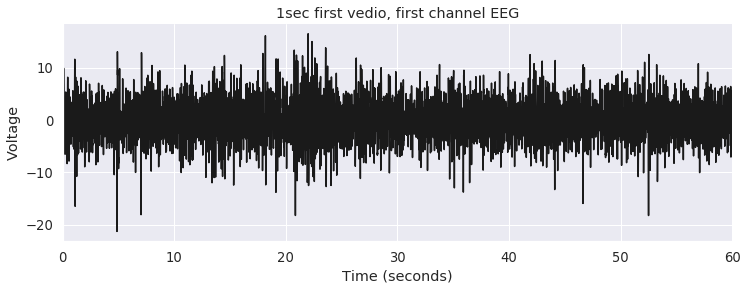

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.2)

# Define sampling frequency and time vector
sf = 128.
time = np.arange(data.size) / sf

# Plot the signal
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
plt.plot(time, data, lw=1.5, color='k')
plt.xlabel('Time (seconds)')
plt.ylabel('Voltage')
plt.xlim([time.min(), time.max()])
plt.title('1sec first vedio, first channel EEG')
plt.savefig("output1.png")

sns.despine()

In [27]:
from scipy import signal

win = 0.5 * sf
freqs, psd = signal.welch(data, sf, nperseg=win)

In [28]:
len(psd)

33

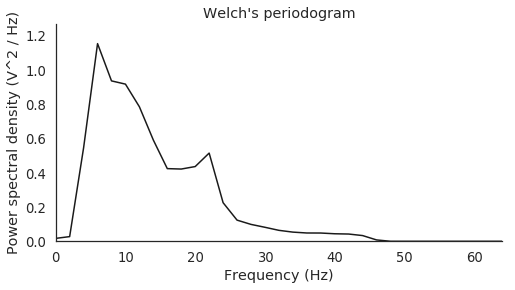

In [29]:
from scipy import signal

# Define window length (1 seconds)
win = 0.5 * sf
freqs, psd = signal.welch(data, sf, nperseg=win)

# Plot the power spectrum
sns.set(font_scale=1.2, style='white')
plt.figure(figsize=(8, 4))
plt.plot(freqs, psd, color='k', lw=1.5)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (V^2 / Hz)')
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
plt.xlim([0, freqs.max()])
plt.savefig("output2.png")

sns.despine()

In [30]:
# Define EEG bands

eeg_bands = {'Delta': (0, 4),
             'Theta': (4, 8),
             'Alpha': (8, 12),
             'Beta':  (12, 30),
             'Gamma': (30, 50)}

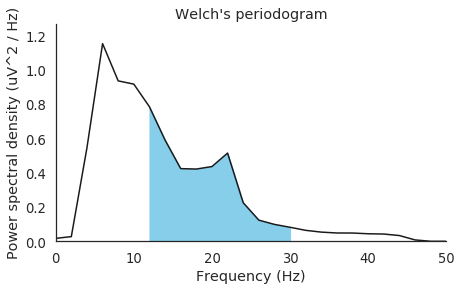

In [31]:
# Define delta lower and upper limits
low, high = eeg_bands['Beta']

# Find intersecting values in frequency vector
idx_delta = np.logical_and(freqs >= low, freqs <= high)

# Plot the power spectral density and fill the delta area
plt.figure(figsize=(7, 4))
plt.plot(freqs, psd, lw=1.5, color='k')
plt.fill_between(freqs, psd, where=idx_delta, color='skyblue')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (uV^2 / Hz)')
plt.xlim([0, 50])
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
plt.savefig("output3.png")

sns.despine()

### Signal Processing

Summarizing single channel signal data and extracting feature from it.

### eeg_features

- power_spectrums(signal)
    - calculates the concatenated vector of the power spectra
    - for the alpha, theta, beta bands
    - via the welch method for estimating spectral density
    
- power_spectrums_specific(signal):
	- calculates the concatenated vector of the power spectra
	- for the alpha, theta, beta bands
	- via the welch method for estimating spectral density
    - list return

In [24]:
a = np.split(data,60)

In [27]:
import numpy as np
import scipy.signal

def make_band(eeg):
    pi = 3.14
    y = np.array(eeg)  # faster array
    L = len(eeg)       # signal length
    fs = 128.0         # frequency sampling 128Hz
    T = 1/fs           # sample time
    t = np.linspace(1,L,L)*T
    M = 128
    f = fs*np.linspace(0,L/10,L/10)/L  # single side frequency vector, real frequency up to fs/2
    Y = np.fft.fft(y)

    filtered = []
    b= [] # store filter coefficient
    cutoff = [0.5,4.0,8.0,12.0,30.0,47] # delta, alpha, theta, beta bands

    for band in range(0, len(cutoff)-1):
        wl = 2*cutoff[band]/fs*pi
        wh = 2*cutoff[band+1]/fs*pi
        M = 128      # Set number of weights as 128
        bn = np.zeros(M)

        for i in range(0,M):     # Generate bandpass weighting function
            n = i-M/2       # Make symmetrical
            if n == 0:
                bn[i] = wh/pi - wl/pi;
            else:
                bn[i] = (np.sin(wh*n))/(pi*n) - (np.sin(wl*n))/(pi*n)   # Filter impulse response

        bn = bn*np.kaiser(M,5.2)  # apply Kaiser window, alpha= 5.2
        b.append(bn)

        [w,h]= scipy.signal.freqz(bn,1)
        filtered.append(np.convolve(bn, y)) # filter the signal by convolving the signal with filter coefficients


    start = int(M/2)
    end = int(L+M/2)
    alpha = filtered[1]
    alpha = np.fft.fft(alpha[start:end]).real
    theta = filtered[2]
    theta = np.fft.fft(theta[start:end]).real
    beta = filtered[3]
    beta = np.fft.fft(beta[start:end]).real
    gamma = filtered[4]
    gamma = np.fft.fft(gamma[start:end]).real
    x = [alpha, beta, gamma]
    x = np.stack(x)
    return x

In [28]:
x = make_band(a[0])
x.shape

/home/vcl/.conda/envs/gct634/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  if sys.path[0] == '':


(3, 128)

In [31]:
def categorize(label):
    if label[0] >= 5 and label[1] >= 5:
        return "HVHA"
    elif label[0] >= 5 and label[1] < 5:
        return "HVLA"
    elif label[0] < 5 and label[1] >= 5:
        return "LVHA"
    elif label[0] < 5 and label[1] < 5:
        return "LVLA"

In [32]:
participants = range(1,33)
videos = range(0,40)
channels = range(1,33)
win = 1 * sf
final_dic = {}
final_label =[]
final_channel = []
for person in participants:
    for vid in videos:
        all_label = []
        all_channels = []
        # 첫 sample의 첫 video 32개 채널 데이터를 호출
        channels_data = (((raw_data_dict[person])['data'])[vid])[:32]
        label = (((raw_data_dict[person])['labels'])[vid])
        label = categorize(label)
        for i in channels_data:
            one_channels = []
            # eeg를 60초로 나눔
            list_channel = np.split(i, 60)
            for j in list_channel:
                # eeg를 32-frequency영역으로 나눔
                x = make_band(j)
                
                # 60 x (3 x 128)
                one_channels.append(x)
            # 32 x 60 x (3 x 128)
            all_channels.append(one_channels)    
            x = np.stack(all_channels)
        # 40 x 60 x (32 x 32 )
        final_channel.append(x)
        final_label.append(label)

/home/vcl/.conda/envs/gct634/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  if sys.path[0] == '':


In [33]:
temp = np.stack(final_channel)
temp.shape

(1280, 32, 60, 3, 128)

In [45]:
a = temp.transpose(0,2,3,1,4)

In [50]:
final = []
for i in a:
    for j in i:
        final.append(j)

In [70]:
final[0].shape

(3, 32, 128)

In [59]:
b = []
for i in final_label:
    for j in range(60):
        b.append(i)

In [60]:
b= np.stack(b)
len(b)

76800

In [66]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(final, b, test_size=0.1, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
train = zip(X_train, y_train)
test = zip(X_test, y_test)
valid = zip(X_valid, y_valid)

In [69]:
import os

for idx, i in enumerate(valid):
    save_path = './dataset/3channel/valid/'+str(i[1])+'/'
    save_name = str(i[1])+'.'+str(idx)+".npy"
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    np.save(os.path.join(save_path, save_name), i[0].astype(np.float32))
    print(os.path.join(save_path, save_name))

./dataset/3channel/valid/HVHA/HVHA.0.npy
./dataset/3channel/valid/LVHA/LVHA.1.npy
./dataset/3channel/valid/HVLA/HVLA.2.npy
./dataset/3channel/valid/LVLA/LVLA.3.npy
./dataset/3channel/valid/LVLA/LVLA.4.npy
./dataset/3channel/valid/HVHA/HVHA.5.npy
./dataset/3channel/valid/LVHA/LVHA.6.npy
./dataset/3channel/valid/LVHA/LVHA.7.npy
./dataset/3channel/valid/HVHA/HVHA.8.npy
./dataset/3channel/valid/HVLA/HVLA.9.npy
./dataset/3channel/valid/HVHA/HVHA.10.npy
./dataset/3channel/valid/HVHA/HVHA.11.npy
./dataset/3channel/valid/LVHA/LVHA.12.npy
./dataset/3channel/valid/HVHA/HVHA.13.npy
./dataset/3channel/valid/HVHA/HVHA.14.npy
./dataset/3channel/valid/LVHA/LVHA.15.npy
./dataset/3channel/valid/LVLA/LVLA.16.npy
./dataset/3channel/valid/HVHA/HVHA.17.npy
./dataset/3channel/valid/HVHA/HVHA.18.npy
./dataset/3channel/valid/HVHA/HVHA.19.npy
./dataset/3channel/valid/HVLA/HVLA.20.npy
./dataset/3channel/valid/HVHA/HVHA.21.npy
./dataset/3channel/valid/HVHA/HVHA.22.npy
./dataset/3channel/valid/HVLA/HVLA.23.npy
./

./dataset/3channel/valid/HVLA/HVLA.361.npy
./dataset/3channel/valid/LVLA/LVLA.362.npy
./dataset/3channel/valid/LVHA/LVHA.363.npy
./dataset/3channel/valid/HVLA/HVLA.364.npy
./dataset/3channel/valid/HVHA/HVHA.365.npy
./dataset/3channel/valid/LVLA/LVLA.366.npy
./dataset/3channel/valid/LVLA/LVLA.367.npy
./dataset/3channel/valid/LVLA/LVLA.368.npy
./dataset/3channel/valid/HVLA/HVLA.369.npy
./dataset/3channel/valid/LVHA/LVHA.370.npy
./dataset/3channel/valid/HVHA/HVHA.371.npy
./dataset/3channel/valid/LVLA/LVLA.372.npy
./dataset/3channel/valid/LVHA/LVHA.373.npy
./dataset/3channel/valid/HVLA/HVLA.374.npy
./dataset/3channel/valid/LVLA/LVLA.375.npy
./dataset/3channel/valid/LVHA/LVHA.376.npy
./dataset/3channel/valid/LVLA/LVLA.377.npy
./dataset/3channel/valid/LVHA/LVHA.378.npy
./dataset/3channel/valid/HVLA/HVLA.379.npy
./dataset/3channel/valid/LVLA/LVLA.380.npy
./dataset/3channel/valid/LVLA/LVLA.381.npy
./dataset/3channel/valid/LVLA/LVLA.382.npy
./dataset/3channel/valid/HVHA/HVHA.383.npy
./dataset/3

./dataset/3channel/valid/HVLA/HVLA.747.npy
./dataset/3channel/valid/HVLA/HVLA.748.npy
./dataset/3channel/valid/HVLA/HVLA.749.npy
./dataset/3channel/valid/HVHA/HVHA.750.npy
./dataset/3channel/valid/LVHA/LVHA.751.npy
./dataset/3channel/valid/HVHA/HVHA.752.npy
./dataset/3channel/valid/LVLA/LVLA.753.npy
./dataset/3channel/valid/LVLA/LVLA.754.npy
./dataset/3channel/valid/HVLA/HVLA.755.npy
./dataset/3channel/valid/HVHA/HVHA.756.npy
./dataset/3channel/valid/HVHA/HVHA.757.npy
./dataset/3channel/valid/LVLA/LVLA.758.npy
./dataset/3channel/valid/HVHA/HVHA.759.npy
./dataset/3channel/valid/HVHA/HVHA.760.npy
./dataset/3channel/valid/LVHA/LVHA.761.npy
./dataset/3channel/valid/LVLA/LVLA.762.npy
./dataset/3channel/valid/LVHA/LVHA.763.npy
./dataset/3channel/valid/LVLA/LVLA.764.npy
./dataset/3channel/valid/HVLA/HVLA.765.npy
./dataset/3channel/valid/LVHA/LVHA.766.npy
./dataset/3channel/valid/LVHA/LVHA.767.npy
./dataset/3channel/valid/HVLA/HVLA.768.npy
./dataset/3channel/valid/HVLA/HVLA.769.npy
./dataset/3

./dataset/3channel/valid/LVLA/LVLA.1141.npy
./dataset/3channel/valid/HVHA/HVHA.1142.npy
./dataset/3channel/valid/HVLA/HVLA.1143.npy
./dataset/3channel/valid/HVHA/HVHA.1144.npy
./dataset/3channel/valid/HVLA/HVLA.1145.npy
./dataset/3channel/valid/HVHA/HVHA.1146.npy
./dataset/3channel/valid/HVHA/HVHA.1147.npy
./dataset/3channel/valid/LVLA/LVLA.1148.npy
./dataset/3channel/valid/HVLA/HVLA.1149.npy
./dataset/3channel/valid/LVLA/LVLA.1150.npy
./dataset/3channel/valid/LVHA/LVHA.1151.npy
./dataset/3channel/valid/HVLA/HVLA.1152.npy
./dataset/3channel/valid/HVHA/HVHA.1153.npy
./dataset/3channel/valid/HVHA/HVHA.1154.npy
./dataset/3channel/valid/HVLA/HVLA.1155.npy
./dataset/3channel/valid/LVHA/LVHA.1156.npy
./dataset/3channel/valid/LVLA/LVLA.1157.npy
./dataset/3channel/valid/HVLA/HVLA.1158.npy
./dataset/3channel/valid/HVLA/HVLA.1159.npy
./dataset/3channel/valid/HVHA/HVHA.1160.npy
./dataset/3channel/valid/LVLA/LVLA.1161.npy
./dataset/3channel/valid/HVHA/HVHA.1162.npy
./dataset/3channel/valid/LVLA/LV

./dataset/3channel/valid/LVHA/LVHA.1535.npy
./dataset/3channel/valid/HVHA/HVHA.1536.npy
./dataset/3channel/valid/LVHA/LVHA.1537.npy
./dataset/3channel/valid/LVLA/LVLA.1538.npy
./dataset/3channel/valid/LVLA/LVLA.1539.npy
./dataset/3channel/valid/LVHA/LVHA.1540.npy
./dataset/3channel/valid/LVLA/LVLA.1541.npy
./dataset/3channel/valid/HVLA/HVLA.1542.npy
./dataset/3channel/valid/HVHA/HVHA.1543.npy
./dataset/3channel/valid/HVHA/HVHA.1544.npy
./dataset/3channel/valid/LVLA/LVLA.1545.npy
./dataset/3channel/valid/HVHA/HVHA.1546.npy
./dataset/3channel/valid/HVHA/HVHA.1547.npy
./dataset/3channel/valid/LVHA/LVHA.1548.npy
./dataset/3channel/valid/HVHA/HVHA.1549.npy
./dataset/3channel/valid/HVHA/HVHA.1550.npy
./dataset/3channel/valid/LVHA/LVHA.1551.npy
./dataset/3channel/valid/HVHA/HVHA.1552.npy
./dataset/3channel/valid/HVLA/HVLA.1553.npy
./dataset/3channel/valid/HVLA/HVLA.1554.npy
./dataset/3channel/valid/HVHA/HVHA.1555.npy
./dataset/3channel/valid/HVHA/HVHA.1556.npy
./dataset/3channel/valid/LVLA/LV

./dataset/3channel/valid/LVHA/LVHA.1920.npy
./dataset/3channel/valid/LVLA/LVLA.1921.npy
./dataset/3channel/valid/HVLA/HVLA.1922.npy
./dataset/3channel/valid/HVLA/HVLA.1923.npy
./dataset/3channel/valid/LVLA/LVLA.1924.npy
./dataset/3channel/valid/HVHA/HVHA.1925.npy
./dataset/3channel/valid/HVHA/HVHA.1926.npy
./dataset/3channel/valid/HVHA/HVHA.1927.npy
./dataset/3channel/valid/HVHA/HVHA.1928.npy
./dataset/3channel/valid/HVLA/HVLA.1929.npy
./dataset/3channel/valid/LVLA/LVLA.1930.npy
./dataset/3channel/valid/HVHA/HVHA.1931.npy
./dataset/3channel/valid/HVHA/HVHA.1932.npy
./dataset/3channel/valid/LVLA/LVLA.1933.npy
./dataset/3channel/valid/HVHA/HVHA.1934.npy
./dataset/3channel/valid/HVLA/HVLA.1935.npy
./dataset/3channel/valid/LVHA/LVHA.1936.npy
./dataset/3channel/valid/LVHA/LVHA.1937.npy
./dataset/3channel/valid/LVLA/LVLA.1938.npy
./dataset/3channel/valid/LVLA/LVLA.1939.npy
./dataset/3channel/valid/HVLA/HVLA.1940.npy
./dataset/3channel/valid/LVHA/LVHA.1941.npy
./dataset/3channel/valid/LVLA/LV

./dataset/3channel/valid/LVLA/LVLA.2308.npy
./dataset/3channel/valid/LVHA/LVHA.2309.npy
./dataset/3channel/valid/LVHA/LVHA.2310.npy
./dataset/3channel/valid/LVHA/LVHA.2311.npy
./dataset/3channel/valid/LVLA/LVLA.2312.npy
./dataset/3channel/valid/HVLA/HVLA.2313.npy
./dataset/3channel/valid/LVLA/LVLA.2314.npy
./dataset/3channel/valid/HVLA/HVLA.2315.npy
./dataset/3channel/valid/LVHA/LVHA.2316.npy
./dataset/3channel/valid/LVHA/LVHA.2317.npy
./dataset/3channel/valid/LVHA/LVHA.2318.npy
./dataset/3channel/valid/LVHA/LVHA.2319.npy
./dataset/3channel/valid/HVLA/HVLA.2320.npy
./dataset/3channel/valid/HVLA/HVLA.2321.npy
./dataset/3channel/valid/LVHA/LVHA.2322.npy
./dataset/3channel/valid/HVHA/HVHA.2323.npy
./dataset/3channel/valid/LVLA/LVLA.2324.npy
./dataset/3channel/valid/HVHA/HVHA.2325.npy
./dataset/3channel/valid/HVHA/HVHA.2326.npy
./dataset/3channel/valid/HVHA/HVHA.2327.npy
./dataset/3channel/valid/HVLA/HVLA.2328.npy
./dataset/3channel/valid/HVHA/HVHA.2329.npy
./dataset/3channel/valid/LVHA/LV

./dataset/3channel/valid/LVHA/LVHA.2692.npy
./dataset/3channel/valid/HVLA/HVLA.2693.npy
./dataset/3channel/valid/HVHA/HVHA.2694.npy
./dataset/3channel/valid/HVLA/HVLA.2695.npy
./dataset/3channel/valid/LVLA/LVLA.2696.npy
./dataset/3channel/valid/HVHA/HVHA.2697.npy
./dataset/3channel/valid/LVHA/LVHA.2698.npy
./dataset/3channel/valid/LVLA/LVLA.2699.npy
./dataset/3channel/valid/HVHA/HVHA.2700.npy
./dataset/3channel/valid/LVLA/LVLA.2701.npy
./dataset/3channel/valid/LVHA/LVHA.2702.npy
./dataset/3channel/valid/HVLA/HVLA.2703.npy
./dataset/3channel/valid/LVHA/LVHA.2704.npy
./dataset/3channel/valid/HVLA/HVLA.2705.npy
./dataset/3channel/valid/HVHA/HVHA.2706.npy
./dataset/3channel/valid/LVLA/LVLA.2707.npy
./dataset/3channel/valid/LVHA/LVHA.2708.npy
./dataset/3channel/valid/HVLA/HVLA.2709.npy
./dataset/3channel/valid/HVHA/HVHA.2710.npy
./dataset/3channel/valid/HVLA/HVLA.2711.npy
./dataset/3channel/valid/LVHA/LVHA.2712.npy
./dataset/3channel/valid/LVHA/LVHA.2713.npy
./dataset/3channel/valid/LVHA/LV

./dataset/3channel/valid/HVHA/HVHA.3078.npy
./dataset/3channel/valid/LVLA/LVLA.3079.npy
./dataset/3channel/valid/LVHA/LVHA.3080.npy
./dataset/3channel/valid/HVHA/HVHA.3081.npy
./dataset/3channel/valid/LVLA/LVLA.3082.npy
./dataset/3channel/valid/LVLA/LVLA.3083.npy
./dataset/3channel/valid/LVLA/LVLA.3084.npy
./dataset/3channel/valid/LVLA/LVLA.3085.npy
./dataset/3channel/valid/HVHA/HVHA.3086.npy
./dataset/3channel/valid/LVLA/LVLA.3087.npy
./dataset/3channel/valid/LVHA/LVHA.3088.npy
./dataset/3channel/valid/LVHA/LVHA.3089.npy
./dataset/3channel/valid/LVHA/LVHA.3090.npy
./dataset/3channel/valid/LVLA/LVLA.3091.npy
./dataset/3channel/valid/LVLA/LVLA.3092.npy
./dataset/3channel/valid/HVHA/HVHA.3093.npy
./dataset/3channel/valid/LVHA/LVHA.3094.npy
./dataset/3channel/valid/LVHA/LVHA.3095.npy
./dataset/3channel/valid/LVHA/LVHA.3096.npy
./dataset/3channel/valid/LVLA/LVLA.3097.npy
./dataset/3channel/valid/HVHA/HVHA.3098.npy
./dataset/3channel/valid/HVHA/HVHA.3099.npy
./dataset/3channel/valid/HVHA/HV

./dataset/3channel/valid/HVHA/HVHA.3464.npy
./dataset/3channel/valid/HVLA/HVLA.3465.npy
./dataset/3channel/valid/HVHA/HVHA.3466.npy
./dataset/3channel/valid/LVLA/LVLA.3467.npy
./dataset/3channel/valid/HVHA/HVHA.3468.npy
./dataset/3channel/valid/HVLA/HVLA.3469.npy
./dataset/3channel/valid/LVLA/LVLA.3470.npy
./dataset/3channel/valid/HVHA/HVHA.3471.npy
./dataset/3channel/valid/LVHA/LVHA.3472.npy
./dataset/3channel/valid/LVHA/LVHA.3473.npy
./dataset/3channel/valid/HVLA/HVLA.3474.npy
./dataset/3channel/valid/LVHA/LVHA.3475.npy
./dataset/3channel/valid/LVHA/LVHA.3476.npy
./dataset/3channel/valid/LVLA/LVLA.3477.npy
./dataset/3channel/valid/HVLA/HVLA.3478.npy
./dataset/3channel/valid/LVLA/LVLA.3479.npy
./dataset/3channel/valid/LVHA/LVHA.3480.npy
./dataset/3channel/valid/LVHA/LVHA.3481.npy
./dataset/3channel/valid/HVLA/HVLA.3482.npy
./dataset/3channel/valid/HVHA/HVHA.3483.npy
./dataset/3channel/valid/LVHA/LVHA.3484.npy
./dataset/3channel/valid/LVHA/LVHA.3485.npy
./dataset/3channel/valid/HVHA/HV

./dataset/3channel/valid/HVHA/HVHA.3850.npy
./dataset/3channel/valid/HVLA/HVLA.3851.npy
./dataset/3channel/valid/LVHA/LVHA.3852.npy
./dataset/3channel/valid/LVHA/LVHA.3853.npy
./dataset/3channel/valid/HVHA/HVHA.3854.npy
./dataset/3channel/valid/LVLA/LVLA.3855.npy
./dataset/3channel/valid/LVLA/LVLA.3856.npy
./dataset/3channel/valid/HVHA/HVHA.3857.npy
./dataset/3channel/valid/HVLA/HVLA.3858.npy
./dataset/3channel/valid/LVLA/LVLA.3859.npy
./dataset/3channel/valid/HVHA/HVHA.3860.npy
./dataset/3channel/valid/HVHA/HVHA.3861.npy
./dataset/3channel/valid/LVLA/LVLA.3862.npy
./dataset/3channel/valid/LVHA/LVHA.3863.npy
./dataset/3channel/valid/HVHA/HVHA.3864.npy
./dataset/3channel/valid/HVHA/HVHA.3865.npy
./dataset/3channel/valid/LVLA/LVLA.3866.npy
./dataset/3channel/valid/HVLA/HVLA.3867.npy
./dataset/3channel/valid/HVHA/HVHA.3868.npy
./dataset/3channel/valid/LVHA/LVHA.3869.npy
./dataset/3channel/valid/HVLA/HVLA.3870.npy
./dataset/3channel/valid/HVHA/HVHA.3871.npy
./dataset/3channel/valid/HVHA/HV

./dataset/3channel/valid/HVHA/HVHA.4221.npy
./dataset/3channel/valid/HVLA/HVLA.4222.npy
./dataset/3channel/valid/HVLA/HVLA.4223.npy
./dataset/3channel/valid/LVLA/LVLA.4224.npy
./dataset/3channel/valid/HVHA/HVHA.4225.npy
./dataset/3channel/valid/HVHA/HVHA.4226.npy
./dataset/3channel/valid/HVHA/HVHA.4227.npy
./dataset/3channel/valid/HVLA/HVLA.4228.npy
./dataset/3channel/valid/HVLA/HVLA.4229.npy
./dataset/3channel/valid/LVLA/LVLA.4230.npy
./dataset/3channel/valid/LVHA/LVHA.4231.npy
./dataset/3channel/valid/LVHA/LVHA.4232.npy
./dataset/3channel/valid/HVHA/HVHA.4233.npy
./dataset/3channel/valid/LVHA/LVHA.4234.npy
./dataset/3channel/valid/HVLA/HVLA.4235.npy
./dataset/3channel/valid/LVHA/LVHA.4236.npy
./dataset/3channel/valid/HVLA/HVLA.4237.npy
./dataset/3channel/valid/HVHA/HVHA.4238.npy
./dataset/3channel/valid/HVLA/HVLA.4239.npy
./dataset/3channel/valid/LVLA/LVLA.4240.npy
./dataset/3channel/valid/LVLA/LVLA.4241.npy
./dataset/3channel/valid/LVHA/LVHA.4242.npy
./dataset/3channel/valid/LVHA/LV

./dataset/3channel/valid/LVHA/LVHA.4609.npy
./dataset/3channel/valid/LVLA/LVLA.4610.npy
./dataset/3channel/valid/LVLA/LVLA.4611.npy
./dataset/3channel/valid/LVLA/LVLA.4612.npy
./dataset/3channel/valid/LVHA/LVHA.4613.npy
./dataset/3channel/valid/LVLA/LVLA.4614.npy
./dataset/3channel/valid/HVHA/HVHA.4615.npy
./dataset/3channel/valid/LVHA/LVHA.4616.npy
./dataset/3channel/valid/HVHA/HVHA.4617.npy
./dataset/3channel/valid/LVHA/LVHA.4618.npy
./dataset/3channel/valid/HVLA/HVLA.4619.npy
./dataset/3channel/valid/HVHA/HVHA.4620.npy
./dataset/3channel/valid/HVLA/HVLA.4621.npy
./dataset/3channel/valid/HVLA/HVLA.4622.npy
./dataset/3channel/valid/LVHA/LVHA.4623.npy
./dataset/3channel/valid/HVHA/HVHA.4624.npy
./dataset/3channel/valid/HVHA/HVHA.4625.npy
./dataset/3channel/valid/LVHA/LVHA.4626.npy
./dataset/3channel/valid/HVHA/HVHA.4627.npy
./dataset/3channel/valid/HVLA/HVLA.4628.npy
./dataset/3channel/valid/LVLA/LVLA.4629.npy
./dataset/3channel/valid/LVHA/LVHA.4630.npy
./dataset/3channel/valid/LVHA/LV

./dataset/3channel/valid/LVHA/LVHA.4986.npy
./dataset/3channel/valid/LVLA/LVLA.4987.npy
./dataset/3channel/valid/HVLA/HVLA.4988.npy
./dataset/3channel/valid/LVLA/LVLA.4989.npy
./dataset/3channel/valid/HVHA/HVHA.4990.npy
./dataset/3channel/valid/HVLA/HVLA.4991.npy
./dataset/3channel/valid/HVLA/HVLA.4992.npy
./dataset/3channel/valid/LVHA/LVHA.4993.npy
./dataset/3channel/valid/HVHA/HVHA.4994.npy
./dataset/3channel/valid/HVLA/HVLA.4995.npy
./dataset/3channel/valid/HVHA/HVHA.4996.npy
./dataset/3channel/valid/HVLA/HVLA.4997.npy
./dataset/3channel/valid/HVHA/HVHA.4998.npy
./dataset/3channel/valid/HVHA/HVHA.4999.npy
./dataset/3channel/valid/HVLA/HVLA.5000.npy
./dataset/3channel/valid/LVHA/LVHA.5001.npy
./dataset/3channel/valid/LVLA/LVLA.5002.npy
./dataset/3channel/valid/LVHA/LVHA.5003.npy
./dataset/3channel/valid/HVLA/HVLA.5004.npy
./dataset/3channel/valid/HVHA/HVHA.5005.npy
./dataset/3channel/valid/LVHA/LVHA.5006.npy
./dataset/3channel/valid/LVLA/LVLA.5007.npy
./dataset/3channel/valid/LVLA/LV

./dataset/3channel/valid/LVHA/LVHA.5382.npy
./dataset/3channel/valid/HVHA/HVHA.5383.npy
./dataset/3channel/valid/LVHA/LVHA.5384.npy
./dataset/3channel/valid/HVHA/HVHA.5385.npy
./dataset/3channel/valid/LVHA/LVHA.5386.npy
./dataset/3channel/valid/HVHA/HVHA.5387.npy
./dataset/3channel/valid/LVLA/LVLA.5388.npy
./dataset/3channel/valid/LVLA/LVLA.5389.npy
./dataset/3channel/valid/LVHA/LVHA.5390.npy
./dataset/3channel/valid/LVLA/LVLA.5391.npy
./dataset/3channel/valid/HVLA/HVLA.5392.npy
./dataset/3channel/valid/LVLA/LVLA.5393.npy
./dataset/3channel/valid/HVHA/HVHA.5394.npy
./dataset/3channel/valid/HVLA/HVLA.5395.npy
./dataset/3channel/valid/LVHA/LVHA.5396.npy
./dataset/3channel/valid/LVHA/LVHA.5397.npy
./dataset/3channel/valid/LVHA/LVHA.5398.npy
./dataset/3channel/valid/LVHA/LVHA.5399.npy
./dataset/3channel/valid/LVHA/LVHA.5400.npy
./dataset/3channel/valid/HVHA/HVHA.5401.npy
./dataset/3channel/valid/HVLA/HVLA.5402.npy
./dataset/3channel/valid/LVLA/LVLA.5403.npy
./dataset/3channel/valid/HVLA/HV

./dataset/3channel/valid/HVHA/HVHA.5766.npy
./dataset/3channel/valid/LVLA/LVLA.5767.npy
./dataset/3channel/valid/LVHA/LVHA.5768.npy
./dataset/3channel/valid/HVLA/HVLA.5769.npy
./dataset/3channel/valid/HVHA/HVHA.5770.npy
./dataset/3channel/valid/HVHA/HVHA.5771.npy
./dataset/3channel/valid/LVHA/LVHA.5772.npy
./dataset/3channel/valid/LVHA/LVHA.5773.npy
./dataset/3channel/valid/HVHA/HVHA.5774.npy
./dataset/3channel/valid/LVHA/LVHA.5775.npy
./dataset/3channel/valid/HVHA/HVHA.5776.npy
./dataset/3channel/valid/LVHA/LVHA.5777.npy
./dataset/3channel/valid/HVHA/HVHA.5778.npy
./dataset/3channel/valid/HVHA/HVHA.5779.npy
./dataset/3channel/valid/LVHA/LVHA.5780.npy
./dataset/3channel/valid/LVHA/LVHA.5781.npy
./dataset/3channel/valid/LVHA/LVHA.5782.npy
./dataset/3channel/valid/LVLA/LVLA.5783.npy
./dataset/3channel/valid/LVHA/LVHA.5784.npy
./dataset/3channel/valid/LVLA/LVLA.5785.npy
./dataset/3channel/valid/HVLA/HVLA.5786.npy
./dataset/3channel/valid/HVHA/HVHA.5787.npy
./dataset/3channel/valid/LVHA/LV

./dataset/3channel/valid/HVHA/HVHA.6162.npy
./dataset/3channel/valid/LVLA/LVLA.6163.npy
./dataset/3channel/valid/HVHA/HVHA.6164.npy
./dataset/3channel/valid/HVLA/HVLA.6165.npy
./dataset/3channel/valid/LVHA/LVHA.6166.npy
./dataset/3channel/valid/HVHA/HVHA.6167.npy
./dataset/3channel/valid/HVHA/HVHA.6168.npy
./dataset/3channel/valid/LVHA/LVHA.6169.npy
./dataset/3channel/valid/HVHA/HVHA.6170.npy
./dataset/3channel/valid/LVLA/LVLA.6171.npy
./dataset/3channel/valid/HVHA/HVHA.6172.npy
./dataset/3channel/valid/HVHA/HVHA.6173.npy
./dataset/3channel/valid/LVLA/LVLA.6174.npy
./dataset/3channel/valid/HVHA/HVHA.6175.npy
./dataset/3channel/valid/LVLA/LVLA.6176.npy
./dataset/3channel/valid/HVLA/HVLA.6177.npy
./dataset/3channel/valid/HVHA/HVHA.6178.npy
./dataset/3channel/valid/LVHA/LVHA.6179.npy
./dataset/3channel/valid/LVLA/LVLA.6180.npy
./dataset/3channel/valid/LVLA/LVLA.6181.npy
./dataset/3channel/valid/LVLA/LVLA.6182.npy
./dataset/3channel/valid/HVLA/HVLA.6183.npy
./dataset/3channel/valid/LVHA/LV

./dataset/3channel/valid/LVHA/LVHA.6558.npy
./dataset/3channel/valid/HVLA/HVLA.6559.npy
./dataset/3channel/valid/HVHA/HVHA.6560.npy
./dataset/3channel/valid/HVHA/HVHA.6561.npy
./dataset/3channel/valid/HVLA/HVLA.6562.npy
./dataset/3channel/valid/HVLA/HVLA.6563.npy
./dataset/3channel/valid/HVLA/HVLA.6564.npy
./dataset/3channel/valid/HVHA/HVHA.6565.npy
./dataset/3channel/valid/LVHA/LVHA.6566.npy
./dataset/3channel/valid/HVLA/HVLA.6567.npy
./dataset/3channel/valid/HVHA/HVHA.6568.npy
./dataset/3channel/valid/LVHA/LVHA.6569.npy
./dataset/3channel/valid/HVHA/HVHA.6570.npy
./dataset/3channel/valid/HVHA/HVHA.6571.npy
./dataset/3channel/valid/LVLA/LVLA.6572.npy
./dataset/3channel/valid/LVLA/LVLA.6573.npy
./dataset/3channel/valid/HVLA/HVLA.6574.npy
./dataset/3channel/valid/LVHA/LVHA.6575.npy
./dataset/3channel/valid/LVLA/LVLA.6576.npy
./dataset/3channel/valid/HVLA/HVLA.6577.npy
./dataset/3channel/valid/HVHA/HVHA.6578.npy
./dataset/3channel/valid/LVHA/LVHA.6579.npy
./dataset/3channel/valid/LVHA/LV

./dataset/3channel/valid/LVLA/LVLA.6971.npy
./dataset/3channel/valid/HVHA/HVHA.6972.npy
./dataset/3channel/valid/LVLA/LVLA.6973.npy
./dataset/3channel/valid/HVHA/HVHA.6974.npy
./dataset/3channel/valid/HVHA/HVHA.6975.npy
./dataset/3channel/valid/LVHA/LVHA.6976.npy
./dataset/3channel/valid/LVHA/LVHA.6977.npy
./dataset/3channel/valid/LVHA/LVHA.6978.npy
./dataset/3channel/valid/LVHA/LVHA.6979.npy
./dataset/3channel/valid/LVHA/LVHA.6980.npy
./dataset/3channel/valid/HVHA/HVHA.6981.npy
./dataset/3channel/valid/LVLA/LVLA.6982.npy
./dataset/3channel/valid/LVLA/LVLA.6983.npy
./dataset/3channel/valid/HVHA/HVHA.6984.npy
./dataset/3channel/valid/LVLA/LVLA.6985.npy
./dataset/3channel/valid/HVHA/HVHA.6986.npy
./dataset/3channel/valid/LVLA/LVLA.6987.npy
./dataset/3channel/valid/HVLA/HVLA.6988.npy
./dataset/3channel/valid/HVLA/HVLA.6989.npy
./dataset/3channel/valid/LVHA/LVHA.6990.npy
./dataset/3channel/valid/LVLA/LVLA.6991.npy
./dataset/3channel/valid/HVLA/HVLA.6992.npy
./dataset/3channel/valid/HVLA/HV

./dataset/3channel/valid/LVLA/LVLA.7381.npy
./dataset/3channel/valid/HVHA/HVHA.7382.npy
./dataset/3channel/valid/HVLA/HVLA.7383.npy
./dataset/3channel/valid/LVLA/LVLA.7384.npy
./dataset/3channel/valid/LVHA/LVHA.7385.npy
./dataset/3channel/valid/HVHA/HVHA.7386.npy
./dataset/3channel/valid/HVLA/HVLA.7387.npy
./dataset/3channel/valid/HVLA/HVLA.7388.npy
./dataset/3channel/valid/LVHA/LVHA.7389.npy
./dataset/3channel/valid/LVLA/LVLA.7390.npy
./dataset/3channel/valid/HVLA/HVLA.7391.npy
./dataset/3channel/valid/LVHA/LVHA.7392.npy
./dataset/3channel/valid/LVLA/LVLA.7393.npy
./dataset/3channel/valid/LVLA/LVLA.7394.npy
./dataset/3channel/valid/HVLA/HVLA.7395.npy
./dataset/3channel/valid/HVLA/HVLA.7396.npy
./dataset/3channel/valid/HVHA/HVHA.7397.npy
./dataset/3channel/valid/LVHA/LVHA.7398.npy
./dataset/3channel/valid/HVHA/HVHA.7399.npy
./dataset/3channel/valid/HVLA/HVLA.7400.npy
./dataset/3channel/valid/LVHA/LVHA.7401.npy
./dataset/3channel/valid/HVHA/HVHA.7402.npy
./dataset/3channel/valid/LVLA/LV

./dataset/3channel/valid/LVHA/LVHA.7789.npy
./dataset/3channel/valid/HVHA/HVHA.7790.npy
./dataset/3channel/valid/HVHA/HVHA.7791.npy
./dataset/3channel/valid/HVHA/HVHA.7792.npy
./dataset/3channel/valid/HVHA/HVHA.7793.npy
./dataset/3channel/valid/HVHA/HVHA.7794.npy
./dataset/3channel/valid/HVHA/HVHA.7795.npy
./dataset/3channel/valid/LVLA/LVLA.7796.npy
./dataset/3channel/valid/HVLA/HVLA.7797.npy
./dataset/3channel/valid/LVHA/LVHA.7798.npy
./dataset/3channel/valid/HVLA/HVLA.7799.npy
./dataset/3channel/valid/HVHA/HVHA.7800.npy
./dataset/3channel/valid/HVHA/HVHA.7801.npy
./dataset/3channel/valid/LVHA/LVHA.7802.npy
./dataset/3channel/valid/HVHA/HVHA.7803.npy
./dataset/3channel/valid/HVHA/HVHA.7804.npy
./dataset/3channel/valid/HVLA/HVLA.7805.npy
./dataset/3channel/valid/LVLA/LVLA.7806.npy
./dataset/3channel/valid/LVLA/LVLA.7807.npy
./dataset/3channel/valid/HVHA/HVHA.7808.npy
./dataset/3channel/valid/LVLA/LVLA.7809.npy
./dataset/3channel/valid/HVHA/HVHA.7810.npy
./dataset/3channel/valid/HVHA/HV

./dataset/3channel/valid/HVHA/HVHA.8181.npy
./dataset/3channel/valid/LVLA/LVLA.8182.npy
./dataset/3channel/valid/HVLA/HVLA.8183.npy
./dataset/3channel/valid/HVLA/HVLA.8184.npy
./dataset/3channel/valid/HVHA/HVHA.8185.npy
./dataset/3channel/valid/HVHA/HVHA.8186.npy
./dataset/3channel/valid/HVHA/HVHA.8187.npy
./dataset/3channel/valid/HVHA/HVHA.8188.npy
./dataset/3channel/valid/HVHA/HVHA.8189.npy
./dataset/3channel/valid/HVHA/HVHA.8190.npy
./dataset/3channel/valid/HVHA/HVHA.8191.npy
./dataset/3channel/valid/LVHA/LVHA.8192.npy
./dataset/3channel/valid/HVHA/HVHA.8193.npy
./dataset/3channel/valid/LVHA/LVHA.8194.npy
./dataset/3channel/valid/HVLA/HVLA.8195.npy
./dataset/3channel/valid/HVHA/HVHA.8196.npy
./dataset/3channel/valid/HVLA/HVLA.8197.npy
./dataset/3channel/valid/HVHA/HVHA.8198.npy
./dataset/3channel/valid/HVHA/HVHA.8199.npy
./dataset/3channel/valid/LVHA/LVHA.8200.npy
./dataset/3channel/valid/LVLA/LVLA.8201.npy
./dataset/3channel/valid/LVLA/LVLA.8202.npy
./dataset/3channel/valid/LVLA/LV

./dataset/3channel/valid/LVHA/LVHA.8567.npy
./dataset/3channel/valid/HVLA/HVLA.8568.npy
./dataset/3channel/valid/HVLA/HVLA.8569.npy
./dataset/3channel/valid/LVHA/LVHA.8570.npy
./dataset/3channel/valid/LVHA/LVHA.8571.npy
./dataset/3channel/valid/LVHA/LVHA.8572.npy
./dataset/3channel/valid/LVHA/LVHA.8573.npy
./dataset/3channel/valid/LVHA/LVHA.8574.npy
./dataset/3channel/valid/LVLA/LVLA.8575.npy
./dataset/3channel/valid/HVLA/HVLA.8576.npy
./dataset/3channel/valid/HVHA/HVHA.8577.npy
./dataset/3channel/valid/LVHA/LVHA.8578.npy
./dataset/3channel/valid/LVLA/LVLA.8579.npy
./dataset/3channel/valid/LVHA/LVHA.8580.npy
./dataset/3channel/valid/HVHA/HVHA.8581.npy
./dataset/3channel/valid/HVHA/HVHA.8582.npy
./dataset/3channel/valid/HVHA/HVHA.8583.npy
./dataset/3channel/valid/LVHA/LVHA.8584.npy
./dataset/3channel/valid/HVHA/HVHA.8585.npy
./dataset/3channel/valid/LVHA/LVHA.8586.npy
./dataset/3channel/valid/HVLA/HVLA.8587.npy
./dataset/3channel/valid/HVHA/HVHA.8588.npy
./dataset/3channel/valid/LVLA/LV

./dataset/3channel/valid/HVHA/HVHA.8962.npy
./dataset/3channel/valid/HVLA/HVLA.8963.npy
./dataset/3channel/valid/HVLA/HVLA.8964.npy
./dataset/3channel/valid/LVHA/LVHA.8965.npy
./dataset/3channel/valid/HVHA/HVHA.8966.npy
./dataset/3channel/valid/HVLA/HVLA.8967.npy
./dataset/3channel/valid/HVLA/HVLA.8968.npy
./dataset/3channel/valid/LVHA/LVHA.8969.npy
./dataset/3channel/valid/HVHA/HVHA.8970.npy
./dataset/3channel/valid/HVLA/HVLA.8971.npy
./dataset/3channel/valid/LVLA/LVLA.8972.npy
./dataset/3channel/valid/HVHA/HVHA.8973.npy
./dataset/3channel/valid/HVHA/HVHA.8974.npy
./dataset/3channel/valid/HVHA/HVHA.8975.npy
./dataset/3channel/valid/LVHA/LVHA.8976.npy
./dataset/3channel/valid/HVLA/HVLA.8977.npy
./dataset/3channel/valid/LVLA/LVLA.8978.npy
./dataset/3channel/valid/LVLA/LVLA.8979.npy
./dataset/3channel/valid/HVHA/HVHA.8980.npy
./dataset/3channel/valid/HVHA/HVHA.8981.npy
./dataset/3channel/valid/HVHA/HVHA.8982.npy
./dataset/3channel/valid/LVHA/LVHA.8983.npy
./dataset/3channel/valid/HVHA/HV

./dataset/3channel/valid/LVLA/LVLA.9369.npy
./dataset/3channel/valid/LVHA/LVHA.9370.npy
./dataset/3channel/valid/HVHA/HVHA.9371.npy
./dataset/3channel/valid/HVLA/HVLA.9372.npy
./dataset/3channel/valid/HVHA/HVHA.9373.npy
./dataset/3channel/valid/HVLA/HVLA.9374.npy
./dataset/3channel/valid/LVLA/LVLA.9375.npy
./dataset/3channel/valid/HVLA/HVLA.9376.npy
./dataset/3channel/valid/LVLA/LVLA.9377.npy
./dataset/3channel/valid/LVLA/LVLA.9378.npy
./dataset/3channel/valid/LVHA/LVHA.9379.npy
./dataset/3channel/valid/LVLA/LVLA.9380.npy
./dataset/3channel/valid/LVHA/LVHA.9381.npy
./dataset/3channel/valid/LVLA/LVLA.9382.npy
./dataset/3channel/valid/HVHA/HVHA.9383.npy
./dataset/3channel/valid/HVHA/HVHA.9384.npy
./dataset/3channel/valid/LVHA/LVHA.9385.npy
./dataset/3channel/valid/HVLA/HVLA.9386.npy
./dataset/3channel/valid/HVHA/HVHA.9387.npy
./dataset/3channel/valid/LVHA/LVHA.9388.npy
./dataset/3channel/valid/LVLA/LVLA.9389.npy
./dataset/3channel/valid/LVHA/LVHA.9390.npy
./dataset/3channel/valid/HVLA/HV

./dataset/3channel/valid/HVHA/HVHA.9735.npy
./dataset/3channel/valid/LVLA/LVLA.9736.npy
./dataset/3channel/valid/HVLA/HVLA.9737.npy
./dataset/3channel/valid/HVHA/HVHA.9738.npy
./dataset/3channel/valid/HVHA/HVHA.9739.npy
./dataset/3channel/valid/HVLA/HVLA.9740.npy
./dataset/3channel/valid/LVLA/LVLA.9741.npy
./dataset/3channel/valid/LVHA/LVHA.9742.npy
./dataset/3channel/valid/HVLA/HVLA.9743.npy
./dataset/3channel/valid/HVLA/HVLA.9744.npy
./dataset/3channel/valid/HVLA/HVLA.9745.npy
./dataset/3channel/valid/LVHA/LVHA.9746.npy
./dataset/3channel/valid/LVHA/LVHA.9747.npy
./dataset/3channel/valid/HVHA/HVHA.9748.npy
./dataset/3channel/valid/LVLA/LVLA.9749.npy
./dataset/3channel/valid/HVLA/HVLA.9750.npy
./dataset/3channel/valid/LVHA/LVHA.9751.npy
./dataset/3channel/valid/HVLA/HVLA.9752.npy
./dataset/3channel/valid/LVHA/LVHA.9753.npy
./dataset/3channel/valid/HVLA/HVLA.9754.npy
./dataset/3channel/valid/HVHA/HVHA.9755.npy
./dataset/3channel/valid/LVLA/LVLA.9756.npy
./dataset/3channel/valid/HVLA/HV

./dataset/3channel/valid/HVLA/HVLA.10127.npy
./dataset/3channel/valid/HVHA/HVHA.10128.npy
./dataset/3channel/valid/HVHA/HVHA.10129.npy
./dataset/3channel/valid/LVHA/LVHA.10130.npy
./dataset/3channel/valid/LVHA/LVHA.10131.npy
./dataset/3channel/valid/LVLA/LVLA.10132.npy
./dataset/3channel/valid/HVHA/HVHA.10133.npy
./dataset/3channel/valid/HVHA/HVHA.10134.npy
./dataset/3channel/valid/LVHA/LVHA.10135.npy
./dataset/3channel/valid/LVLA/LVLA.10136.npy
./dataset/3channel/valid/HVHA/HVHA.10137.npy
./dataset/3channel/valid/LVHA/LVHA.10138.npy
./dataset/3channel/valid/HVLA/HVLA.10139.npy
./dataset/3channel/valid/HVHA/HVHA.10140.npy
./dataset/3channel/valid/LVHA/LVHA.10141.npy
./dataset/3channel/valid/HVHA/HVHA.10142.npy
./dataset/3channel/valid/HVHA/HVHA.10143.npy
./dataset/3channel/valid/HVLA/HVLA.10144.npy
./dataset/3channel/valid/HVHA/HVHA.10145.npy
./dataset/3channel/valid/HVHA/HVHA.10146.npy
./dataset/3channel/valid/HVHA/HVHA.10147.npy
./dataset/3channel/valid/LVHA/LVHA.10148.npy
./dataset/

./dataset/3channel/valid/HVHA/HVHA.10536.npy
./dataset/3channel/valid/LVHA/LVHA.10537.npy
./dataset/3channel/valid/LVLA/LVLA.10538.npy
./dataset/3channel/valid/LVLA/LVLA.10539.npy
./dataset/3channel/valid/LVHA/LVHA.10540.npy
./dataset/3channel/valid/HVLA/HVLA.10541.npy
./dataset/3channel/valid/LVLA/LVLA.10542.npy
./dataset/3channel/valid/LVLA/LVLA.10543.npy
./dataset/3channel/valid/HVLA/HVLA.10544.npy
./dataset/3channel/valid/HVLA/HVLA.10545.npy
./dataset/3channel/valid/LVLA/LVLA.10546.npy
./dataset/3channel/valid/HVHA/HVHA.10547.npy
./dataset/3channel/valid/LVLA/LVLA.10548.npy
./dataset/3channel/valid/HVLA/HVLA.10549.npy
./dataset/3channel/valid/HVHA/HVHA.10550.npy
./dataset/3channel/valid/HVHA/HVHA.10551.npy
./dataset/3channel/valid/LVLA/LVLA.10552.npy
./dataset/3channel/valid/LVLA/LVLA.10553.npy
./dataset/3channel/valid/HVLA/HVLA.10554.npy
./dataset/3channel/valid/HVLA/HVLA.10555.npy
./dataset/3channel/valid/HVHA/HVHA.10556.npy
./dataset/3channel/valid/HVLA/HVLA.10557.npy
./dataset/

./dataset/3channel/valid/LVLA/LVLA.10940.npy
./dataset/3channel/valid/LVLA/LVLA.10941.npy
./dataset/3channel/valid/HVHA/HVHA.10942.npy
./dataset/3channel/valid/HVHA/HVHA.10943.npy
./dataset/3channel/valid/LVHA/LVHA.10944.npy
./dataset/3channel/valid/LVHA/LVHA.10945.npy
./dataset/3channel/valid/HVLA/HVLA.10946.npy
./dataset/3channel/valid/LVHA/LVHA.10947.npy
./dataset/3channel/valid/HVLA/HVLA.10948.npy
./dataset/3channel/valid/LVLA/LVLA.10949.npy
./dataset/3channel/valid/HVHA/HVHA.10950.npy
./dataset/3channel/valid/HVLA/HVLA.10951.npy
./dataset/3channel/valid/LVLA/LVLA.10952.npy
./dataset/3channel/valid/HVLA/HVLA.10953.npy
./dataset/3channel/valid/HVHA/HVHA.10954.npy
./dataset/3channel/valid/LVHA/LVHA.10955.npy
./dataset/3channel/valid/HVLA/HVLA.10956.npy
./dataset/3channel/valid/HVHA/HVHA.10957.npy
./dataset/3channel/valid/HVHA/HVHA.10958.npy
./dataset/3channel/valid/HVHA/HVHA.10959.npy
./dataset/3channel/valid/LVHA/LVHA.10960.npy
./dataset/3channel/valid/HVHA/HVHA.10961.npy
./dataset/

./dataset/3channel/valid/HVHA/HVHA.11325.npy
./dataset/3channel/valid/HVLA/HVLA.11326.npy
./dataset/3channel/valid/HVLA/HVLA.11327.npy
./dataset/3channel/valid/LVHA/LVHA.11328.npy
./dataset/3channel/valid/HVHA/HVHA.11329.npy
./dataset/3channel/valid/LVHA/LVHA.11330.npy
./dataset/3channel/valid/LVHA/LVHA.11331.npy
./dataset/3channel/valid/HVLA/HVLA.11332.npy
./dataset/3channel/valid/HVLA/HVLA.11333.npy
./dataset/3channel/valid/LVHA/LVHA.11334.npy
./dataset/3channel/valid/LVHA/LVHA.11335.npy
./dataset/3channel/valid/HVLA/HVLA.11336.npy
./dataset/3channel/valid/HVHA/HVHA.11337.npy
./dataset/3channel/valid/HVHA/HVHA.11338.npy
./dataset/3channel/valid/HVLA/HVLA.11339.npy
./dataset/3channel/valid/LVHA/LVHA.11340.npy
./dataset/3channel/valid/HVLA/HVLA.11341.npy
./dataset/3channel/valid/HVHA/HVHA.11342.npy
./dataset/3channel/valid/HVHA/HVHA.11343.npy
./dataset/3channel/valid/HVLA/HVLA.11344.npy
./dataset/3channel/valid/HVHA/HVHA.11345.npy
./dataset/3channel/valid/HVLA/HVLA.11346.npy
./dataset/

./dataset/3channel/valid/LVLA/LVLA.11693.npy
./dataset/3channel/valid/HVLA/HVLA.11694.npy
./dataset/3channel/valid/LVLA/LVLA.11695.npy
./dataset/3channel/valid/HVHA/HVHA.11696.npy
./dataset/3channel/valid/HVHA/HVHA.11697.npy
./dataset/3channel/valid/LVHA/LVHA.11698.npy
./dataset/3channel/valid/LVHA/LVHA.11699.npy
./dataset/3channel/valid/HVHA/HVHA.11700.npy
./dataset/3channel/valid/HVHA/HVHA.11701.npy
./dataset/3channel/valid/LVHA/LVHA.11702.npy
./dataset/3channel/valid/HVHA/HVHA.11703.npy
./dataset/3channel/valid/LVHA/LVHA.11704.npy
./dataset/3channel/valid/LVHA/LVHA.11705.npy
./dataset/3channel/valid/HVHA/HVHA.11706.npy
./dataset/3channel/valid/HVLA/HVLA.11707.npy
./dataset/3channel/valid/HVHA/HVHA.11708.npy
./dataset/3channel/valid/LVHA/LVHA.11709.npy
./dataset/3channel/valid/HVHA/HVHA.11710.npy
./dataset/3channel/valid/LVLA/LVLA.11711.npy
./dataset/3channel/valid/LVHA/LVHA.11712.npy
./dataset/3channel/valid/HVLA/HVLA.11713.npy
./dataset/3channel/valid/LVLA/LVLA.11714.npy
./dataset/

./dataset/3channel/valid/HVHA/HVHA.12083.npy
./dataset/3channel/valid/LVLA/LVLA.12084.npy
./dataset/3channel/valid/HVHA/HVHA.12085.npy
./dataset/3channel/valid/LVLA/LVLA.12086.npy
./dataset/3channel/valid/LVLA/LVLA.12087.npy
./dataset/3channel/valid/LVLA/LVLA.12088.npy
./dataset/3channel/valid/HVHA/HVHA.12089.npy
./dataset/3channel/valid/HVHA/HVHA.12090.npy
./dataset/3channel/valid/HVHA/HVHA.12091.npy
./dataset/3channel/valid/HVHA/HVHA.12092.npy
./dataset/3channel/valid/HVHA/HVHA.12093.npy
./dataset/3channel/valid/HVLA/HVLA.12094.npy
./dataset/3channel/valid/HVLA/HVLA.12095.npy
./dataset/3channel/valid/HVHA/HVHA.12096.npy
./dataset/3channel/valid/LVHA/LVHA.12097.npy
./dataset/3channel/valid/LVHA/LVHA.12098.npy
./dataset/3channel/valid/HVLA/HVLA.12099.npy
./dataset/3channel/valid/HVHA/HVHA.12100.npy
./dataset/3channel/valid/HVHA/HVHA.12101.npy
./dataset/3channel/valid/LVHA/LVHA.12102.npy
./dataset/3channel/valid/LVLA/LVLA.12103.npy
./dataset/3channel/valid/LVHA/LVHA.12104.npy
./dataset/

./dataset/3channel/valid/LVLA/LVLA.12486.npy
./dataset/3channel/valid/LVLA/LVLA.12487.npy
./dataset/3channel/valid/HVHA/HVHA.12488.npy
./dataset/3channel/valid/LVHA/LVHA.12489.npy
./dataset/3channel/valid/HVHA/HVHA.12490.npy
./dataset/3channel/valid/LVLA/LVLA.12491.npy
./dataset/3channel/valid/LVLA/LVLA.12492.npy
./dataset/3channel/valid/HVHA/HVHA.12493.npy
./dataset/3channel/valid/HVLA/HVLA.12494.npy
./dataset/3channel/valid/HVHA/HVHA.12495.npy
./dataset/3channel/valid/LVHA/LVHA.12496.npy
./dataset/3channel/valid/HVHA/HVHA.12497.npy
./dataset/3channel/valid/HVHA/HVHA.12498.npy
./dataset/3channel/valid/LVHA/LVHA.12499.npy
./dataset/3channel/valid/HVHA/HVHA.12500.npy
./dataset/3channel/valid/HVHA/HVHA.12501.npy
./dataset/3channel/valid/HVHA/HVHA.12502.npy
./dataset/3channel/valid/HVHA/HVHA.12503.npy
./dataset/3channel/valid/HVLA/HVLA.12504.npy
./dataset/3channel/valid/LVHA/LVHA.12505.npy
./dataset/3channel/valid/HVLA/HVLA.12506.npy
./dataset/3channel/valid/HVHA/HVHA.12507.npy
./dataset/

./dataset/3channel/valid/LVHA/LVHA.12870.npy
./dataset/3channel/valid/LVHA/LVHA.12871.npy
./dataset/3channel/valid/HVHA/HVHA.12872.npy
./dataset/3channel/valid/LVHA/LVHA.12873.npy
./dataset/3channel/valid/LVLA/LVLA.12874.npy
./dataset/3channel/valid/HVLA/HVLA.12875.npy
./dataset/3channel/valid/LVHA/LVHA.12876.npy
./dataset/3channel/valid/HVHA/HVHA.12877.npy
./dataset/3channel/valid/LVLA/LVLA.12878.npy
./dataset/3channel/valid/LVLA/LVLA.12879.npy
./dataset/3channel/valid/HVLA/HVLA.12880.npy
./dataset/3channel/valid/HVHA/HVHA.12881.npy
./dataset/3channel/valid/LVHA/LVHA.12882.npy
./dataset/3channel/valid/LVLA/LVLA.12883.npy
./dataset/3channel/valid/LVLA/LVLA.12884.npy
./dataset/3channel/valid/HVHA/HVHA.12885.npy
./dataset/3channel/valid/LVLA/LVLA.12886.npy
./dataset/3channel/valid/LVLA/LVLA.12887.npy
./dataset/3channel/valid/LVHA/LVHA.12888.npy
./dataset/3channel/valid/LVHA/LVHA.12889.npy
./dataset/3channel/valid/HVLA/HVLA.12890.npy
./dataset/3channel/valid/LVHA/LVHA.12891.npy
./dataset/

./dataset/3channel/valid/LVHA/LVHA.13260.npy
./dataset/3channel/valid/LVHA/LVHA.13261.npy
./dataset/3channel/valid/LVHA/LVHA.13262.npy
./dataset/3channel/valid/LVHA/LVHA.13263.npy
./dataset/3channel/valid/LVHA/LVHA.13264.npy
./dataset/3channel/valid/LVLA/LVLA.13265.npy
./dataset/3channel/valid/HVHA/HVHA.13266.npy
./dataset/3channel/valid/LVLA/LVLA.13267.npy
./dataset/3channel/valid/LVLA/LVLA.13268.npy
./dataset/3channel/valid/LVLA/LVLA.13269.npy
./dataset/3channel/valid/HVHA/HVHA.13270.npy
./dataset/3channel/valid/HVHA/HVHA.13271.npy
./dataset/3channel/valid/LVLA/LVLA.13272.npy
./dataset/3channel/valid/LVHA/LVHA.13273.npy
./dataset/3channel/valid/HVHA/HVHA.13274.npy
./dataset/3channel/valid/LVLA/LVLA.13275.npy
./dataset/3channel/valid/HVLA/HVLA.13276.npy
./dataset/3channel/valid/HVLA/HVLA.13277.npy
./dataset/3channel/valid/HVHA/HVHA.13278.npy
./dataset/3channel/valid/HVHA/HVHA.13279.npy
./dataset/3channel/valid/HVHA/HVHA.13280.npy
./dataset/3channel/valid/LVHA/LVHA.13281.npy
./dataset/

./dataset/3channel/valid/HVLA/HVLA.13636.npy
./dataset/3channel/valid/HVLA/HVLA.13637.npy
./dataset/3channel/valid/HVLA/HVLA.13638.npy
./dataset/3channel/valid/LVHA/LVHA.13639.npy
./dataset/3channel/valid/HVHA/HVHA.13640.npy
./dataset/3channel/valid/LVLA/LVLA.13641.npy
./dataset/3channel/valid/LVLA/LVLA.13642.npy
./dataset/3channel/valid/HVHA/HVHA.13643.npy
./dataset/3channel/valid/LVHA/LVHA.13644.npy
./dataset/3channel/valid/LVLA/LVLA.13645.npy
./dataset/3channel/valid/HVLA/HVLA.13646.npy
./dataset/3channel/valid/LVHA/LVHA.13647.npy
./dataset/3channel/valid/HVHA/HVHA.13648.npy
./dataset/3channel/valid/HVHA/HVHA.13649.npy
./dataset/3channel/valid/LVHA/LVHA.13650.npy
./dataset/3channel/valid/HVLA/HVLA.13651.npy
./dataset/3channel/valid/LVLA/LVLA.13652.npy
./dataset/3channel/valid/LVLA/LVLA.13653.npy
./dataset/3channel/valid/HVLA/HVLA.13654.npy
./dataset/3channel/valid/HVHA/HVHA.13655.npy
./dataset/3channel/valid/HVLA/HVLA.13656.npy
./dataset/3channel/valid/LVHA/LVHA.13657.npy
./dataset/

In [31]:
def categorize(label):
    if label[0] >= 5 and label[1] >= 5:
        return "HVHA"
    elif label[0] >= 5 and label[1] < 5:
        return "HVLA"
    elif label[0] < 5 and label[1] >= 5:
        return "LVHA"
    elif label[0] < 5 and label[1] < 5:
        return "LVLA"

In [39]:
participants = range(1,33)
videos = range(0,40)
channels = range(1,33)
win = 1 * sf
final_dic = {}
final_label =[]
final_channel = []
for person in participants:
    for vid in videos:
        all_label = []
        all_channels = []
        # 첫 sample의 첫 video 32개 채널 데이터를 호출
        channels_data = (((raw_data_dict[person])['data'])[vid])[:32]
        label = (((raw_data_dict[person])['labels'])[vid])
        label = categorize(label)
        for i in channels_data:
            one_channels = []
            # eeg를 60초로 나눔
            list_channel = np.split(i, 60)
            for j in list_channel:
                # eeg를 32-frequency영역으로 나눔
                freqs, psd = signal.welch(j, sf, nperseg=win)
                # 60 x 32
                one_channels.append(psd[:32])
            all_label.append(label)
            # 32 x (60 x 32)
            all_channels.append(one_channels)    
            x = np.stack(all_channels)
            y = np.stack(all_label)
            # 60 x (32 x 32)
            x = x.transpose(1,0,2)
        # 40 x 60 x (32 x 32 )
        final_channel.extend(x)
        final_label.extend(all_label)
        

In [50]:
len(final_channel)

76800

In [82]:
a = np.stack(final_channel)
a.shape

(76800, 32, 32)

In [48]:
test = []
for person in participants:
    for vid in videos:
        all_label = []
        all_channels = []
        channels_data = (((raw_data_dict[person])['data'])[vid])[:32]
        label = (((raw_data_dict[person])['labels'])[vid])
        label = categorize(label)
        test.append(label)

In [80]:
label = new

In [103]:
b = np.stack(label)
b.shape

(76800,)

In [111]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(a, b, test_size=0.1, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [114]:
len(X_train), len(X_test), len(X_valid)

(55296, 7680, 13824)

In [128]:
train = zip(X_train, y_train)
test = zip(X_test, y_test)
valid = zip(X_valid, y_valid)

In [120]:
for i in train:
    print(i, i[0].shape)
    break

(array([[4.69478441e-03, 1.83260363e-03, 1.35204924e-03, ...,
        8.83377193e-02, 6.53882887e-01, 1.88817304e-01],
       [2.79716585e-02, 1.50951399e-02, 9.00881817e-04, ...,
        3.70974330e-01, 3.33313785e-01, 3.02072198e-01],
       [3.34047306e-03, 2.48210758e-03, 4.96895351e-04, ...,
        7.67794293e-02, 8.97246962e-03, 1.29135799e-01],
       ...,
       [2.80248007e-03, 3.19436466e-04, 3.61496407e-03, ...,
        6.13071544e-01, 4.24544423e-01, 4.82676062e-01],
       [1.53934139e-03, 1.57123509e-03, 8.02354777e-04, ...,
        2.13288322e-01, 7.81317732e-02, 6.24189017e-02],
       [1.46414174e-02, 7.26466218e-03, 1.67302215e-03, ...,
        1.12126997e-01, 1.77578814e-02, 2.60271680e-01]]), 'HVHA') (32, 32)


In [131]:
import os

for idx, i in enumerate(valid):
    save_path = './dataset/eeg_image/valid/'+str(i[1])+'/'
    save_name = str(i[1])+'.'+str(idx)+".npy"
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    np.save(os.path.join(save_path, save_name), i[0].astype(np.float32))
    print(os.path.join(save_path, save_name))

./dataset/eeg_image/valid/HVHA/HVHA.0.npy
./dataset/eeg_image/valid/LVHA/LVHA.1.npy
./dataset/eeg_image/valid/HVLA/HVLA.2.npy
./dataset/eeg_image/valid/LVLA/LVLA.3.npy
./dataset/eeg_image/valid/LVLA/LVLA.4.npy
./dataset/eeg_image/valid/HVHA/HVHA.5.npy
./dataset/eeg_image/valid/LVHA/LVHA.6.npy
./dataset/eeg_image/valid/LVHA/LVHA.7.npy
./dataset/eeg_image/valid/HVHA/HVHA.8.npy
./dataset/eeg_image/valid/HVLA/HVLA.9.npy
./dataset/eeg_image/valid/HVHA/HVHA.10.npy
./dataset/eeg_image/valid/HVHA/HVHA.11.npy
./dataset/eeg_image/valid/LVHA/LVHA.12.npy
./dataset/eeg_image/valid/HVHA/HVHA.13.npy
./dataset/eeg_image/valid/HVHA/HVHA.14.npy
./dataset/eeg_image/valid/LVHA/LVHA.15.npy
./dataset/eeg_image/valid/LVLA/LVLA.16.npy
./dataset/eeg_image/valid/HVHA/HVHA.17.npy
./dataset/eeg_image/valid/HVHA/HVHA.18.npy
./dataset/eeg_image/valid/HVHA/HVHA.19.npy
./dataset/eeg_image/valid/HVLA/HVLA.20.npy
./dataset/eeg_image/valid/HVHA/HVHA.21.npy
./dataset/eeg_image/valid/HVHA/HVHA.22.npy
./dataset/eeg_image/v

./dataset/eeg_image/valid/HVHA/HVHA.563.npy
./dataset/eeg_image/valid/LVHA/LVHA.564.npy
./dataset/eeg_image/valid/HVHA/HVHA.565.npy
./dataset/eeg_image/valid/HVLA/HVLA.566.npy
./dataset/eeg_image/valid/HVLA/HVLA.567.npy
./dataset/eeg_image/valid/HVHA/HVHA.568.npy
./dataset/eeg_image/valid/HVHA/HVHA.569.npy
./dataset/eeg_image/valid/LVHA/LVHA.570.npy
./dataset/eeg_image/valid/HVHA/HVHA.571.npy
./dataset/eeg_image/valid/HVLA/HVLA.572.npy
./dataset/eeg_image/valid/LVLA/LVLA.573.npy
./dataset/eeg_image/valid/HVLA/HVLA.574.npy
./dataset/eeg_image/valid/HVHA/HVHA.575.npy
./dataset/eeg_image/valid/HVLA/HVLA.576.npy
./dataset/eeg_image/valid/LVLA/LVLA.577.npy
./dataset/eeg_image/valid/LVLA/LVLA.578.npy
./dataset/eeg_image/valid/HVLA/HVLA.579.npy
./dataset/eeg_image/valid/HVHA/HVHA.580.npy
./dataset/eeg_image/valid/HVHA/HVHA.581.npy
./dataset/eeg_image/valid/HVHA/HVHA.582.npy
./dataset/eeg_image/valid/LVLA/LVLA.583.npy
./dataset/eeg_image/valid/HVHA/HVHA.584.npy
./dataset/eeg_image/valid/HVHA/H

./dataset/eeg_image/valid/LVLA/LVLA.1163.npy
./dataset/eeg_image/valid/HVHA/HVHA.1164.npy
./dataset/eeg_image/valid/HVLA/HVLA.1165.npy
./dataset/eeg_image/valid/LVHA/LVHA.1166.npy
./dataset/eeg_image/valid/HVHA/HVHA.1167.npy
./dataset/eeg_image/valid/HVLA/HVLA.1168.npy
./dataset/eeg_image/valid/HVHA/HVHA.1169.npy
./dataset/eeg_image/valid/LVHA/LVHA.1170.npy
./dataset/eeg_image/valid/HVHA/HVHA.1171.npy
./dataset/eeg_image/valid/HVLA/HVLA.1172.npy
./dataset/eeg_image/valid/LVHA/LVHA.1173.npy
./dataset/eeg_image/valid/LVHA/LVHA.1174.npy
./dataset/eeg_image/valid/HVLA/HVLA.1175.npy
./dataset/eeg_image/valid/HVHA/HVHA.1176.npy
./dataset/eeg_image/valid/LVHA/LVHA.1177.npy
./dataset/eeg_image/valid/HVHA/HVHA.1178.npy
./dataset/eeg_image/valid/LVHA/LVHA.1179.npy
./dataset/eeg_image/valid/HVLA/HVLA.1180.npy
./dataset/eeg_image/valid/LVLA/LVLA.1181.npy
./dataset/eeg_image/valid/HVHA/HVHA.1182.npy
./dataset/eeg_image/valid/HVLA/HVLA.1183.npy
./dataset/eeg_image/valid/LVHA/LVHA.1184.npy
./dataset/

./dataset/eeg_image/valid/HVLA/HVLA.1781.npy
./dataset/eeg_image/valid/HVHA/HVHA.1782.npy
./dataset/eeg_image/valid/LVLA/LVLA.1783.npy
./dataset/eeg_image/valid/HVHA/HVHA.1784.npy
./dataset/eeg_image/valid/LVHA/LVHA.1785.npy
./dataset/eeg_image/valid/HVHA/HVHA.1786.npy
./dataset/eeg_image/valid/LVLA/LVLA.1787.npy
./dataset/eeg_image/valid/HVHA/HVHA.1788.npy
./dataset/eeg_image/valid/HVHA/HVHA.1789.npy
./dataset/eeg_image/valid/LVLA/LVLA.1790.npy
./dataset/eeg_image/valid/LVHA/LVHA.1791.npy
./dataset/eeg_image/valid/LVLA/LVLA.1792.npy
./dataset/eeg_image/valid/HVHA/HVHA.1793.npy
./dataset/eeg_image/valid/HVLA/HVLA.1794.npy
./dataset/eeg_image/valid/LVLA/LVLA.1795.npy
./dataset/eeg_image/valid/HVLA/HVLA.1796.npy
./dataset/eeg_image/valid/LVLA/LVLA.1797.npy
./dataset/eeg_image/valid/LVHA/LVHA.1798.npy
./dataset/eeg_image/valid/LVHA/LVHA.1799.npy
./dataset/eeg_image/valid/LVHA/LVHA.1800.npy
./dataset/eeg_image/valid/HVLA/HVLA.1801.npy
./dataset/eeg_image/valid/HVHA/HVHA.1802.npy
./dataset/

./dataset/eeg_image/valid/HVLA/HVLA.2346.npy
./dataset/eeg_image/valid/LVHA/LVHA.2347.npy
./dataset/eeg_image/valid/HVHA/HVHA.2348.npy
./dataset/eeg_image/valid/LVLA/LVLA.2349.npy
./dataset/eeg_image/valid/LVLA/LVLA.2350.npy
./dataset/eeg_image/valid/HVHA/HVHA.2351.npy
./dataset/eeg_image/valid/HVHA/HVHA.2352.npy
./dataset/eeg_image/valid/HVHA/HVHA.2353.npy
./dataset/eeg_image/valid/HVLA/HVLA.2354.npy
./dataset/eeg_image/valid/LVHA/LVHA.2355.npy
./dataset/eeg_image/valid/HVLA/HVLA.2356.npy
./dataset/eeg_image/valid/HVHA/HVHA.2357.npy
./dataset/eeg_image/valid/HVHA/HVHA.2358.npy
./dataset/eeg_image/valid/LVLA/LVLA.2359.npy
./dataset/eeg_image/valid/HVLA/HVLA.2360.npy
./dataset/eeg_image/valid/HVHA/HVHA.2361.npy
./dataset/eeg_image/valid/HVHA/HVHA.2362.npy
./dataset/eeg_image/valid/LVLA/LVLA.2363.npy
./dataset/eeg_image/valid/HVHA/HVHA.2364.npy
./dataset/eeg_image/valid/HVHA/HVHA.2365.npy
./dataset/eeg_image/valid/LVLA/LVLA.2366.npy
./dataset/eeg_image/valid/HVHA/HVHA.2367.npy
./dataset/

./dataset/eeg_image/valid/HVLA/HVLA.2917.npy
./dataset/eeg_image/valid/HVHA/HVHA.2918.npy
./dataset/eeg_image/valid/HVHA/HVHA.2919.npy
./dataset/eeg_image/valid/HVHA/HVHA.2920.npy
./dataset/eeg_image/valid/LVLA/LVLA.2921.npy
./dataset/eeg_image/valid/LVLA/LVLA.2922.npy
./dataset/eeg_image/valid/HVHA/HVHA.2923.npy
./dataset/eeg_image/valid/LVHA/LVHA.2924.npy
./dataset/eeg_image/valid/HVHA/HVHA.2925.npy
./dataset/eeg_image/valid/HVLA/HVLA.2926.npy
./dataset/eeg_image/valid/HVLA/HVLA.2927.npy
./dataset/eeg_image/valid/LVLA/LVLA.2928.npy
./dataset/eeg_image/valid/HVLA/HVLA.2929.npy
./dataset/eeg_image/valid/LVHA/LVHA.2930.npy
./dataset/eeg_image/valid/LVHA/LVHA.2931.npy
./dataset/eeg_image/valid/HVHA/HVHA.2932.npy
./dataset/eeg_image/valid/HVHA/HVHA.2933.npy
./dataset/eeg_image/valid/HVLA/HVLA.2934.npy
./dataset/eeg_image/valid/LVLA/LVLA.2935.npy
./dataset/eeg_image/valid/LVLA/LVLA.2936.npy
./dataset/eeg_image/valid/HVHA/HVHA.2937.npy
./dataset/eeg_image/valid/LVHA/LVHA.2938.npy
./dataset/

./dataset/eeg_image/valid/LVLA/LVLA.3460.npy
./dataset/eeg_image/valid/HVHA/HVHA.3461.npy
./dataset/eeg_image/valid/LVHA/LVHA.3462.npy
./dataset/eeg_image/valid/HVHA/HVHA.3463.npy
./dataset/eeg_image/valid/HVHA/HVHA.3464.npy
./dataset/eeg_image/valid/HVLA/HVLA.3465.npy
./dataset/eeg_image/valid/HVHA/HVHA.3466.npy
./dataset/eeg_image/valid/LVLA/LVLA.3467.npy
./dataset/eeg_image/valid/HVHA/HVHA.3468.npy
./dataset/eeg_image/valid/HVLA/HVLA.3469.npy
./dataset/eeg_image/valid/LVLA/LVLA.3470.npy
./dataset/eeg_image/valid/HVHA/HVHA.3471.npy
./dataset/eeg_image/valid/LVHA/LVHA.3472.npy
./dataset/eeg_image/valid/LVHA/LVHA.3473.npy
./dataset/eeg_image/valid/HVLA/HVLA.3474.npy
./dataset/eeg_image/valid/LVHA/LVHA.3475.npy
./dataset/eeg_image/valid/LVHA/LVHA.3476.npy
./dataset/eeg_image/valid/LVLA/LVLA.3477.npy
./dataset/eeg_image/valid/HVLA/HVLA.3478.npy
./dataset/eeg_image/valid/LVLA/LVLA.3479.npy
./dataset/eeg_image/valid/LVHA/LVHA.3480.npy
./dataset/eeg_image/valid/LVHA/LVHA.3481.npy
./dataset/

./dataset/eeg_image/valid/LVLA/LVLA.4013.npy
./dataset/eeg_image/valid/HVLA/HVLA.4014.npy
./dataset/eeg_image/valid/HVHA/HVHA.4015.npy
./dataset/eeg_image/valid/HVHA/HVHA.4016.npy
./dataset/eeg_image/valid/HVLA/HVLA.4017.npy
./dataset/eeg_image/valid/LVLA/LVLA.4018.npy
./dataset/eeg_image/valid/LVLA/LVLA.4019.npy
./dataset/eeg_image/valid/HVLA/HVLA.4020.npy
./dataset/eeg_image/valid/HVHA/HVHA.4021.npy
./dataset/eeg_image/valid/HVHA/HVHA.4022.npy
./dataset/eeg_image/valid/HVHA/HVHA.4023.npy
./dataset/eeg_image/valid/HVHA/HVHA.4024.npy
./dataset/eeg_image/valid/HVHA/HVHA.4025.npy
./dataset/eeg_image/valid/LVHA/LVHA.4026.npy
./dataset/eeg_image/valid/HVHA/HVHA.4027.npy
./dataset/eeg_image/valid/HVHA/HVHA.4028.npy
./dataset/eeg_image/valid/LVHA/LVHA.4029.npy
./dataset/eeg_image/valid/HVHA/HVHA.4030.npy
./dataset/eeg_image/valid/HVLA/HVLA.4031.npy
./dataset/eeg_image/valid/HVHA/HVHA.4032.npy
./dataset/eeg_image/valid/HVLA/HVLA.4033.npy
./dataset/eeg_image/valid/HVHA/HVHA.4034.npy
./dataset/

./dataset/eeg_image/valid/HVLA/HVLA.4553.npy
./dataset/eeg_image/valid/HVLA/HVLA.4554.npy
./dataset/eeg_image/valid/HVHA/HVHA.4555.npy
./dataset/eeg_image/valid/HVHA/HVHA.4556.npy
./dataset/eeg_image/valid/HVHA/HVHA.4557.npy
./dataset/eeg_image/valid/LVHA/LVHA.4558.npy
./dataset/eeg_image/valid/LVLA/LVLA.4559.npy
./dataset/eeg_image/valid/LVHA/LVHA.4560.npy
./dataset/eeg_image/valid/LVHA/LVHA.4561.npy
./dataset/eeg_image/valid/HVHA/HVHA.4562.npy
./dataset/eeg_image/valid/HVLA/HVLA.4563.npy
./dataset/eeg_image/valid/HVHA/HVHA.4564.npy
./dataset/eeg_image/valid/HVHA/HVHA.4565.npy
./dataset/eeg_image/valid/HVHA/HVHA.4566.npy
./dataset/eeg_image/valid/LVHA/LVHA.4567.npy
./dataset/eeg_image/valid/HVLA/HVLA.4568.npy
./dataset/eeg_image/valid/HVHA/HVHA.4569.npy
./dataset/eeg_image/valid/LVHA/LVHA.4570.npy
./dataset/eeg_image/valid/HVHA/HVHA.4571.npy
./dataset/eeg_image/valid/LVHA/LVHA.4572.npy
./dataset/eeg_image/valid/LVLA/LVLA.4573.npy
./dataset/eeg_image/valid/HVLA/HVLA.4574.npy
./dataset/

./dataset/eeg_image/valid/HVHA/HVHA.5119.npy
./dataset/eeg_image/valid/LVLA/LVLA.5120.npy
./dataset/eeg_image/valid/LVHA/LVHA.5121.npy
./dataset/eeg_image/valid/HVHA/HVHA.5122.npy
./dataset/eeg_image/valid/LVLA/LVLA.5123.npy
./dataset/eeg_image/valid/LVLA/LVLA.5124.npy
./dataset/eeg_image/valid/LVHA/LVHA.5125.npy
./dataset/eeg_image/valid/LVLA/LVLA.5126.npy
./dataset/eeg_image/valid/LVLA/LVLA.5127.npy
./dataset/eeg_image/valid/HVHA/HVHA.5128.npy
./dataset/eeg_image/valid/LVHA/LVHA.5129.npy
./dataset/eeg_image/valid/HVHA/HVHA.5130.npy
./dataset/eeg_image/valid/LVLA/LVLA.5131.npy
./dataset/eeg_image/valid/HVHA/HVHA.5132.npy
./dataset/eeg_image/valid/LVLA/LVLA.5133.npy
./dataset/eeg_image/valid/LVHA/LVHA.5134.npy
./dataset/eeg_image/valid/LVHA/LVHA.5135.npy
./dataset/eeg_image/valid/LVLA/LVLA.5136.npy
./dataset/eeg_image/valid/HVLA/HVLA.5137.npy
./dataset/eeg_image/valid/HVLA/HVLA.5138.npy
./dataset/eeg_image/valid/HVLA/HVLA.5139.npy
./dataset/eeg_image/valid/HVLA/HVLA.5140.npy
./dataset/

./dataset/eeg_image/valid/HVLA/HVLA.5726.npy
./dataset/eeg_image/valid/LVHA/LVHA.5727.npy
./dataset/eeg_image/valid/LVHA/LVHA.5728.npy
./dataset/eeg_image/valid/HVHA/HVHA.5729.npy
./dataset/eeg_image/valid/LVHA/LVHA.5730.npy
./dataset/eeg_image/valid/HVHA/HVHA.5731.npy
./dataset/eeg_image/valid/HVHA/HVHA.5732.npy
./dataset/eeg_image/valid/LVLA/LVLA.5733.npy
./dataset/eeg_image/valid/LVHA/LVHA.5734.npy
./dataset/eeg_image/valid/HVHA/HVHA.5735.npy
./dataset/eeg_image/valid/HVHA/HVHA.5736.npy
./dataset/eeg_image/valid/LVLA/LVLA.5737.npy
./dataset/eeg_image/valid/HVLA/HVLA.5738.npy
./dataset/eeg_image/valid/LVHA/LVHA.5739.npy
./dataset/eeg_image/valid/LVLA/LVLA.5740.npy
./dataset/eeg_image/valid/LVHA/LVHA.5741.npy
./dataset/eeg_image/valid/LVLA/LVLA.5742.npy
./dataset/eeg_image/valid/LVLA/LVLA.5743.npy
./dataset/eeg_image/valid/HVHA/HVHA.5744.npy
./dataset/eeg_image/valid/LVLA/LVLA.5745.npy
./dataset/eeg_image/valid/HVHA/HVHA.5746.npy
./dataset/eeg_image/valid/HVHA/HVHA.5747.npy
./dataset/

./dataset/eeg_image/valid/HVLA/HVLA.6325.npy
./dataset/eeg_image/valid/LVHA/LVHA.6326.npy
./dataset/eeg_image/valid/LVHA/LVHA.6327.npy
./dataset/eeg_image/valid/LVLA/LVLA.6328.npy
./dataset/eeg_image/valid/HVLA/HVLA.6329.npy
./dataset/eeg_image/valid/HVLA/HVLA.6330.npy
./dataset/eeg_image/valid/HVHA/HVHA.6331.npy
./dataset/eeg_image/valid/LVHA/LVHA.6332.npy
./dataset/eeg_image/valid/HVHA/HVHA.6333.npy
./dataset/eeg_image/valid/HVHA/HVHA.6334.npy
./dataset/eeg_image/valid/HVHA/HVHA.6335.npy
./dataset/eeg_image/valid/LVLA/LVLA.6336.npy
./dataset/eeg_image/valid/HVLA/HVLA.6337.npy
./dataset/eeg_image/valid/HVHA/HVHA.6338.npy
./dataset/eeg_image/valid/HVLA/HVLA.6339.npy
./dataset/eeg_image/valid/HVHA/HVHA.6340.npy
./dataset/eeg_image/valid/LVHA/LVHA.6341.npy
./dataset/eeg_image/valid/LVHA/LVHA.6342.npy
./dataset/eeg_image/valid/LVHA/LVHA.6343.npy
./dataset/eeg_image/valid/HVLA/HVLA.6344.npy
./dataset/eeg_image/valid/HVLA/HVLA.6345.npy
./dataset/eeg_image/valid/HVHA/HVHA.6346.npy
./dataset/

./dataset/eeg_image/valid/HVLA/HVLA.6891.npy
./dataset/eeg_image/valid/HVHA/HVHA.6892.npy
./dataset/eeg_image/valid/HVHA/HVHA.6893.npy
./dataset/eeg_image/valid/LVLA/LVLA.6894.npy
./dataset/eeg_image/valid/HVLA/HVLA.6895.npy
./dataset/eeg_image/valid/LVLA/LVLA.6896.npy
./dataset/eeg_image/valid/LVHA/LVHA.6897.npy
./dataset/eeg_image/valid/HVHA/HVHA.6898.npy
./dataset/eeg_image/valid/HVLA/HVLA.6899.npy
./dataset/eeg_image/valid/HVLA/HVLA.6900.npy
./dataset/eeg_image/valid/LVHA/LVHA.6901.npy
./dataset/eeg_image/valid/HVHA/HVHA.6902.npy
./dataset/eeg_image/valid/HVHA/HVHA.6903.npy
./dataset/eeg_image/valid/LVHA/LVHA.6904.npy
./dataset/eeg_image/valid/HVHA/HVHA.6905.npy
./dataset/eeg_image/valid/LVHA/LVHA.6906.npy
./dataset/eeg_image/valid/LVHA/LVHA.6907.npy
./dataset/eeg_image/valid/HVHA/HVHA.6908.npy
./dataset/eeg_image/valid/LVLA/LVLA.6909.npy
./dataset/eeg_image/valid/LVHA/LVHA.6910.npy
./dataset/eeg_image/valid/LVLA/LVLA.6911.npy
./dataset/eeg_image/valid/HVHA/HVHA.6912.npy
./dataset/

./dataset/eeg_image/valid/LVHA/LVHA.7461.npy
./dataset/eeg_image/valid/HVHA/HVHA.7462.npy
./dataset/eeg_image/valid/HVLA/HVLA.7463.npy
./dataset/eeg_image/valid/LVLA/LVLA.7464.npy
./dataset/eeg_image/valid/HVHA/HVHA.7465.npy
./dataset/eeg_image/valid/HVHA/HVHA.7466.npy
./dataset/eeg_image/valid/LVHA/LVHA.7467.npy
./dataset/eeg_image/valid/HVHA/HVHA.7468.npy
./dataset/eeg_image/valid/LVLA/LVLA.7469.npy
./dataset/eeg_image/valid/LVHA/LVHA.7470.npy
./dataset/eeg_image/valid/HVHA/HVHA.7471.npy
./dataset/eeg_image/valid/HVHA/HVHA.7472.npy
./dataset/eeg_image/valid/LVHA/LVHA.7473.npy
./dataset/eeg_image/valid/LVHA/LVHA.7474.npy
./dataset/eeg_image/valid/LVHA/LVHA.7475.npy
./dataset/eeg_image/valid/HVHA/HVHA.7476.npy
./dataset/eeg_image/valid/HVLA/HVLA.7477.npy
./dataset/eeg_image/valid/HVLA/HVLA.7478.npy
./dataset/eeg_image/valid/LVLA/LVLA.7479.npy
./dataset/eeg_image/valid/LVLA/LVLA.7480.npy
./dataset/eeg_image/valid/LVHA/LVHA.7481.npy
./dataset/eeg_image/valid/LVHA/LVHA.7482.npy
./dataset/

./dataset/eeg_image/valid/LVLA/LVLA.8073.npy
./dataset/eeg_image/valid/LVLA/LVLA.8074.npy
./dataset/eeg_image/valid/LVHA/LVHA.8075.npy
./dataset/eeg_image/valid/HVHA/HVHA.8076.npy
./dataset/eeg_image/valid/HVHA/HVHA.8077.npy
./dataset/eeg_image/valid/LVHA/LVHA.8078.npy
./dataset/eeg_image/valid/LVHA/LVHA.8079.npy
./dataset/eeg_image/valid/HVHA/HVHA.8080.npy
./dataset/eeg_image/valid/LVHA/LVHA.8081.npy
./dataset/eeg_image/valid/LVHA/LVHA.8082.npy
./dataset/eeg_image/valid/LVLA/LVLA.8083.npy
./dataset/eeg_image/valid/HVLA/HVLA.8084.npy
./dataset/eeg_image/valid/LVHA/LVHA.8085.npy
./dataset/eeg_image/valid/HVHA/HVHA.8086.npy
./dataset/eeg_image/valid/LVLA/LVLA.8087.npy
./dataset/eeg_image/valid/HVHA/HVHA.8088.npy
./dataset/eeg_image/valid/LVLA/LVLA.8089.npy
./dataset/eeg_image/valid/LVHA/LVHA.8090.npy
./dataset/eeg_image/valid/HVHA/HVHA.8091.npy
./dataset/eeg_image/valid/HVLA/HVLA.8092.npy
./dataset/eeg_image/valid/HVLA/HVLA.8093.npy
./dataset/eeg_image/valid/LVHA/LVHA.8094.npy
./dataset/

./dataset/eeg_image/valid/HVHA/HVHA.8693.npy
./dataset/eeg_image/valid/HVHA/HVHA.8694.npy
./dataset/eeg_image/valid/HVLA/HVLA.8695.npy
./dataset/eeg_image/valid/LVHA/LVHA.8696.npy
./dataset/eeg_image/valid/LVHA/LVHA.8697.npy
./dataset/eeg_image/valid/HVLA/HVLA.8698.npy
./dataset/eeg_image/valid/LVLA/LVLA.8699.npy
./dataset/eeg_image/valid/LVHA/LVHA.8700.npy
./dataset/eeg_image/valid/LVHA/LVHA.8701.npy
./dataset/eeg_image/valid/HVHA/HVHA.8702.npy
./dataset/eeg_image/valid/HVLA/HVLA.8703.npy
./dataset/eeg_image/valid/HVLA/HVLA.8704.npy
./dataset/eeg_image/valid/HVHA/HVHA.8705.npy
./dataset/eeg_image/valid/HVHA/HVHA.8706.npy
./dataset/eeg_image/valid/HVHA/HVHA.8707.npy
./dataset/eeg_image/valid/LVHA/LVHA.8708.npy
./dataset/eeg_image/valid/HVHA/HVHA.8709.npy
./dataset/eeg_image/valid/HVHA/HVHA.8710.npy
./dataset/eeg_image/valid/HVLA/HVLA.8711.npy
./dataset/eeg_image/valid/LVLA/LVLA.8712.npy
./dataset/eeg_image/valid/LVLA/LVLA.8713.npy
./dataset/eeg_image/valid/HVLA/HVLA.8714.npy
./dataset/

./dataset/eeg_image/valid/HVHA/HVHA.9285.npy
./dataset/eeg_image/valid/LVLA/LVLA.9286.npy
./dataset/eeg_image/valid/LVHA/LVHA.9287.npy
./dataset/eeg_image/valid/LVLA/LVLA.9288.npy
./dataset/eeg_image/valid/HVLA/HVLA.9289.npy
./dataset/eeg_image/valid/LVHA/LVHA.9290.npy
./dataset/eeg_image/valid/LVLA/LVLA.9291.npy
./dataset/eeg_image/valid/HVHA/HVHA.9292.npy
./dataset/eeg_image/valid/LVLA/LVLA.9293.npy
./dataset/eeg_image/valid/LVLA/LVLA.9294.npy
./dataset/eeg_image/valid/HVHA/HVHA.9295.npy
./dataset/eeg_image/valid/HVHA/HVHA.9296.npy
./dataset/eeg_image/valid/HVLA/HVLA.9297.npy
./dataset/eeg_image/valid/HVHA/HVHA.9298.npy
./dataset/eeg_image/valid/HVLA/HVLA.9299.npy
./dataset/eeg_image/valid/LVLA/LVLA.9300.npy
./dataset/eeg_image/valid/HVHA/HVHA.9301.npy
./dataset/eeg_image/valid/LVLA/LVLA.9302.npy
./dataset/eeg_image/valid/HVLA/HVLA.9303.npy
./dataset/eeg_image/valid/HVHA/HVHA.9304.npy
./dataset/eeg_image/valid/HVHA/HVHA.9305.npy
./dataset/eeg_image/valid/HVHA/HVHA.9306.npy
./dataset/

./dataset/eeg_image/valid/HVHA/HVHA.9856.npy
./dataset/eeg_image/valid/HVLA/HVLA.9857.npy
./dataset/eeg_image/valid/HVHA/HVHA.9858.npy
./dataset/eeg_image/valid/HVHA/HVHA.9859.npy
./dataset/eeg_image/valid/HVHA/HVHA.9860.npy
./dataset/eeg_image/valid/HVHA/HVHA.9861.npy
./dataset/eeg_image/valid/LVHA/LVHA.9862.npy
./dataset/eeg_image/valid/HVLA/HVLA.9863.npy
./dataset/eeg_image/valid/HVHA/HVHA.9864.npy
./dataset/eeg_image/valid/HVHA/HVHA.9865.npy
./dataset/eeg_image/valid/HVHA/HVHA.9866.npy
./dataset/eeg_image/valid/HVLA/HVLA.9867.npy
./dataset/eeg_image/valid/HVLA/HVLA.9868.npy
./dataset/eeg_image/valid/LVHA/LVHA.9869.npy
./dataset/eeg_image/valid/LVHA/LVHA.9870.npy
./dataset/eeg_image/valid/HVHA/HVHA.9871.npy
./dataset/eeg_image/valid/HVLA/HVLA.9872.npy
./dataset/eeg_image/valid/LVHA/LVHA.9873.npy
./dataset/eeg_image/valid/HVLA/HVLA.9874.npy
./dataset/eeg_image/valid/HVLA/HVLA.9875.npy
./dataset/eeg_image/valid/HVHA/HVHA.9876.npy
./dataset/eeg_image/valid/LVLA/LVLA.9877.npy
./dataset/

./dataset/eeg_image/valid/LVHA/LVHA.10434.npy
./dataset/eeg_image/valid/LVHA/LVHA.10435.npy
./dataset/eeg_image/valid/HVHA/HVHA.10436.npy
./dataset/eeg_image/valid/LVHA/LVHA.10437.npy
./dataset/eeg_image/valid/LVLA/LVLA.10438.npy
./dataset/eeg_image/valid/LVHA/LVHA.10439.npy
./dataset/eeg_image/valid/HVHA/HVHA.10440.npy
./dataset/eeg_image/valid/LVHA/LVHA.10441.npy
./dataset/eeg_image/valid/HVHA/HVHA.10442.npy
./dataset/eeg_image/valid/HVHA/HVHA.10443.npy
./dataset/eeg_image/valid/HVLA/HVLA.10444.npy
./dataset/eeg_image/valid/LVHA/LVHA.10445.npy
./dataset/eeg_image/valid/HVLA/HVLA.10446.npy
./dataset/eeg_image/valid/LVLA/LVLA.10447.npy
./dataset/eeg_image/valid/HVLA/HVLA.10448.npy
./dataset/eeg_image/valid/LVLA/LVLA.10449.npy
./dataset/eeg_image/valid/HVLA/HVLA.10450.npy
./dataset/eeg_image/valid/HVHA/HVHA.10451.npy
./dataset/eeg_image/valid/LVHA/LVHA.10452.npy
./dataset/eeg_image/valid/HVLA/HVLA.10453.npy
./dataset/eeg_image/valid/HVLA/HVLA.10454.npy
./dataset/eeg_image/valid/LVLA/LVL

./dataset/eeg_image/valid/HVHA/HVHA.11075.npy
./dataset/eeg_image/valid/LVHA/LVHA.11076.npy
./dataset/eeg_image/valid/LVLA/LVLA.11077.npy
./dataset/eeg_image/valid/HVHA/HVHA.11078.npy
./dataset/eeg_image/valid/HVHA/HVHA.11079.npy
./dataset/eeg_image/valid/HVHA/HVHA.11080.npy
./dataset/eeg_image/valid/HVHA/HVHA.11081.npy
./dataset/eeg_image/valid/LVLA/LVLA.11082.npy
./dataset/eeg_image/valid/LVLA/LVLA.11083.npy
./dataset/eeg_image/valid/HVHA/HVHA.11084.npy
./dataset/eeg_image/valid/HVHA/HVHA.11085.npy
./dataset/eeg_image/valid/LVHA/LVHA.11086.npy
./dataset/eeg_image/valid/HVLA/HVLA.11087.npy
./dataset/eeg_image/valid/LVLA/LVLA.11088.npy
./dataset/eeg_image/valid/LVLA/LVLA.11089.npy
./dataset/eeg_image/valid/HVHA/HVHA.11090.npy
./dataset/eeg_image/valid/HVLA/HVLA.11091.npy
./dataset/eeg_image/valid/HVLA/HVLA.11092.npy
./dataset/eeg_image/valid/HVLA/HVLA.11093.npy
./dataset/eeg_image/valid/LVLA/LVLA.11094.npy
./dataset/eeg_image/valid/HVHA/HVHA.11095.npy
./dataset/eeg_image/valid/HVHA/HVH

./dataset/eeg_image/valid/LVHA/LVHA.11669.npy
./dataset/eeg_image/valid/HVHA/HVHA.11670.npy
./dataset/eeg_image/valid/HVLA/HVLA.11671.npy
./dataset/eeg_image/valid/LVHA/LVHA.11672.npy
./dataset/eeg_image/valid/HVHA/HVHA.11673.npy
./dataset/eeg_image/valid/LVLA/LVLA.11674.npy
./dataset/eeg_image/valid/LVLA/LVLA.11675.npy
./dataset/eeg_image/valid/LVHA/LVHA.11676.npy
./dataset/eeg_image/valid/LVLA/LVLA.11677.npy
./dataset/eeg_image/valid/LVHA/LVHA.11678.npy
./dataset/eeg_image/valid/HVLA/HVLA.11679.npy
./dataset/eeg_image/valid/LVLA/LVLA.11680.npy
./dataset/eeg_image/valid/LVHA/LVHA.11681.npy
./dataset/eeg_image/valid/HVLA/HVLA.11682.npy
./dataset/eeg_image/valid/LVHA/LVHA.11683.npy
./dataset/eeg_image/valid/HVHA/HVHA.11684.npy
./dataset/eeg_image/valid/LVHA/LVHA.11685.npy
./dataset/eeg_image/valid/HVLA/HVLA.11686.npy
./dataset/eeg_image/valid/LVHA/LVHA.11687.npy
./dataset/eeg_image/valid/LVHA/LVHA.11688.npy
./dataset/eeg_image/valid/LVHA/LVHA.11689.npy
./dataset/eeg_image/valid/HVHA/HVH

./dataset/eeg_image/valid/HVLA/HVLA.12298.npy
./dataset/eeg_image/valid/LVHA/LVHA.12299.npy
./dataset/eeg_image/valid/HVHA/HVHA.12300.npy
./dataset/eeg_image/valid/LVLA/LVLA.12301.npy
./dataset/eeg_image/valid/HVHA/HVHA.12302.npy
./dataset/eeg_image/valid/LVLA/LVLA.12303.npy
./dataset/eeg_image/valid/LVHA/LVHA.12304.npy
./dataset/eeg_image/valid/LVLA/LVLA.12305.npy
./dataset/eeg_image/valid/LVHA/LVHA.12306.npy
./dataset/eeg_image/valid/HVHA/HVHA.12307.npy
./dataset/eeg_image/valid/LVLA/LVLA.12308.npy
./dataset/eeg_image/valid/LVLA/LVLA.12309.npy
./dataset/eeg_image/valid/HVHA/HVHA.12310.npy
./dataset/eeg_image/valid/LVLA/LVLA.12311.npy
./dataset/eeg_image/valid/HVLA/HVLA.12312.npy
./dataset/eeg_image/valid/HVHA/HVHA.12313.npy
./dataset/eeg_image/valid/LVHA/LVHA.12314.npy
./dataset/eeg_image/valid/HVLA/HVLA.12315.npy
./dataset/eeg_image/valid/HVHA/HVHA.12316.npy
./dataset/eeg_image/valid/HVHA/HVHA.12317.npy
./dataset/eeg_image/valid/HVHA/HVHA.12318.npy
./dataset/eeg_image/valid/LVHA/LVH

./dataset/eeg_image/valid/LVLA/LVLA.12810.npy
./dataset/eeg_image/valid/LVLA/LVLA.12811.npy
./dataset/eeg_image/valid/HVHA/HVHA.12812.npy
./dataset/eeg_image/valid/HVHA/HVHA.12813.npy
./dataset/eeg_image/valid/LVHA/LVHA.12814.npy
./dataset/eeg_image/valid/HVLA/HVLA.12815.npy
./dataset/eeg_image/valid/LVLA/LVLA.12816.npy
./dataset/eeg_image/valid/HVHA/HVHA.12817.npy
./dataset/eeg_image/valid/LVLA/LVLA.12818.npy
./dataset/eeg_image/valid/LVHA/LVHA.12819.npy
./dataset/eeg_image/valid/HVHA/HVHA.12820.npy
./dataset/eeg_image/valid/HVLA/HVLA.12821.npy
./dataset/eeg_image/valid/LVHA/LVHA.12822.npy
./dataset/eeg_image/valid/HVHA/HVHA.12823.npy
./dataset/eeg_image/valid/HVHA/HVHA.12824.npy
./dataset/eeg_image/valid/HVLA/HVLA.12825.npy
./dataset/eeg_image/valid/LVHA/LVHA.12826.npy
./dataset/eeg_image/valid/HVHA/HVHA.12827.npy
./dataset/eeg_image/valid/HVHA/HVHA.12828.npy
./dataset/eeg_image/valid/LVHA/LVHA.12829.npy
./dataset/eeg_image/valid/LVLA/LVLA.12830.npy
./dataset/eeg_image/valid/LVLA/LVL

./dataset/eeg_image/valid/HVHA/HVHA.13423.npy
./dataset/eeg_image/valid/HVHA/HVHA.13424.npy
./dataset/eeg_image/valid/HVHA/HVHA.13425.npy
./dataset/eeg_image/valid/HVLA/HVLA.13426.npy
./dataset/eeg_image/valid/HVLA/HVLA.13427.npy
./dataset/eeg_image/valid/HVHA/HVHA.13428.npy
./dataset/eeg_image/valid/HVLA/HVLA.13429.npy
./dataset/eeg_image/valid/LVLA/LVLA.13430.npy
./dataset/eeg_image/valid/HVLA/HVLA.13431.npy
./dataset/eeg_image/valid/LVHA/LVHA.13432.npy
./dataset/eeg_image/valid/HVHA/HVHA.13433.npy
./dataset/eeg_image/valid/HVLA/HVLA.13434.npy
./dataset/eeg_image/valid/HVHA/HVHA.13435.npy
./dataset/eeg_image/valid/LVLA/LVLA.13436.npy
./dataset/eeg_image/valid/LVHA/LVHA.13437.npy
./dataset/eeg_image/valid/LVHA/LVHA.13438.npy
./dataset/eeg_image/valid/LVHA/LVHA.13439.npy
./dataset/eeg_image/valid/LVLA/LVLA.13440.npy
./dataset/eeg_image/valid/HVHA/HVHA.13441.npy
./dataset/eeg_image/valid/HVHA/HVHA.13442.npy
./dataset/eeg_image/valid/HVHA/HVHA.13443.npy
./dataset/eeg_image/valid/LVHA/LVH

In [32]:
participants = range(1,33)
videos = range(0,40)
channels = range(1,33)
win = 1 * sf
final_dic = {}
final_label =[]
final_channel = []
for person in participants:
    for vid in videos:
        all_label = []
        all_channels = []
        # 첫 sample의 첫 video 32개 채널 데이터를 호출
        channels_data = (((raw_data_dict[person])['data'])[vid])[:32]
        label = (((raw_data_dict[person])['labels'])[vid])
        label = categorize(label)
        for i in channels_data:
            one_channels = []
            # eeg를 60초로 나눔
            list_channel = np.split(i, 60)
            for j in list_channel:
                # eeg를 32-frequency영역으로 나눔
                freqs, psd = signal.welch(j, sf, nperseg=win)
                # 60 x 32
                one_channels.append(psd[:32])
            # 32 x (60 x 32)
            all_channels.append(one_channels)    
            x = np.stack(all_channels)
        # 40 x 60 x (32 x 32 )
        final_channel.append(x)
        final_label.append(label)

In [57]:
x = np.transpose(final_channel,(0,2,1,3))
x = np.expand_dims(x, axis=2)

In [58]:
a = np.stack(x)

a.shape

(1280, 60, 1, 32, 32)

In [52]:
labels = []
for i in final_label:
    labels.append(i[0])

b = np.stack(labels)
b.shape

(1280,)

In [59]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(a, b, test_size=0.1, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [60]:
train = zip(X_train, y_train)
test = zip(X_test, y_test)
valid = zip(X_valid, y_valid)

In [63]:
import os

for idx, i in enumerate(valid):
    save_path = './dataset/eeg_3d_time/valid/'+str(i[1])+'/'
    save_name = str(i[1])+'.'+str(idx)+".npy"
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    np.save(os.path.join(save_path, save_name), i[0].astype(np.float32))
    print(os.path.join(save_path, save_name))

./dataset/eeg_3d_time/valid/HVHA/HVHA.0.npy
./dataset/eeg_3d_time/valid/LVHA/LVHA.1.npy
./dataset/eeg_3d_time/valid/HVLA/HVLA.2.npy
./dataset/eeg_3d_time/valid/LVLA/LVLA.3.npy
./dataset/eeg_3d_time/valid/HVHA/HVHA.4.npy
./dataset/eeg_3d_time/valid/LVLA/LVLA.5.npy
./dataset/eeg_3d_time/valid/LVHA/LVHA.6.npy
./dataset/eeg_3d_time/valid/HVLA/HVLA.7.npy
./dataset/eeg_3d_time/valid/HVLA/HVLA.8.npy
./dataset/eeg_3d_time/valid/LVLA/LVLA.9.npy
./dataset/eeg_3d_time/valid/LVLA/LVLA.10.npy
./dataset/eeg_3d_time/valid/HVLA/HVLA.11.npy
./dataset/eeg_3d_time/valid/HVLA/HVLA.12.npy
./dataset/eeg_3d_time/valid/HVLA/HVLA.13.npy
./dataset/eeg_3d_time/valid/LVLA/LVLA.14.npy
./dataset/eeg_3d_time/valid/LVHA/LVHA.15.npy
./dataset/eeg_3d_time/valid/LVHA/LVHA.16.npy
./dataset/eeg_3d_time/valid/HVLA/HVLA.17.npy
./dataset/eeg_3d_time/valid/HVHA/HVHA.18.npy
./dataset/eeg_3d_time/valid/LVLA/LVLA.19.npy
./dataset/eeg_3d_time/valid/HVLA/HVLA.20.npy
./dataset/eeg_3d_time/valid/LVHA/LVHA.21.npy
./dataset/eeg_3d_tim